In [1]:
import cobra
import cameo
import math
import escher
import plotly

import numpy as np
from scipy import stats
import pandas as pd
import sympy as sy
import colorcet as cc

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so

from datetime import date, datetime

date = datetime.strftime(datetime.now(), '%Y-%m-%d')

# Main Code#

**Instructions:** Run cell above and all cells/functions below main code before running main code

**Note:** 
- Product dependent parameters (i.e., parameters than can change based on the type of ECR product) are imported via external .xlsx files
- Product independent parameters (e.g., electricity price, CO2 price, etc.) are defined within the code (worst, base, and best case values)
- Background info / sources are provided in the notes section at the end of the doc

In [2]:
#Global Vars:
#Change the input directory as needed for your own personal device (i.e., input folder and output folder)
inputDirectory_general = 'C://Users//austi//Documents//eCO2R TEA Code//ecor-tea//Input//'
outputDirectory_general = 'C://Users//austi//Documents//eCO2R TEA Code//ecor-tea//Output//'
ECRfileName = 'ECR_Parameters-2AZ.xlsx'
FBAfileName = 'FBA_OverallSummary-UPDATED_2022-02-13AZ.xlsx'
PathwaysfileName = 'AssimilationPathways_2021-5-13.xlsx'
PSAPrice = 0.25/0.78 #kWh/m3 (all /0.78 for USD to CAD conversion)
DistPrice = 412.29/0.78 #$/hr - for 1000L/min
NFPrice = 0.00243/0.78 #$/L solution

In [33]:
##---Main---##

productionRate = [25, 'ECR'] #[tonnes/h, Bio or ECR]
electrodeArea = 10**5 #m^2
rate = True #True to back-calculate based on production rate, False to calculate from electrode area
case = 'Category_2' #Base, Worst or Best / Category_1
analysisType = 'Categories' #Realistic (values from literature), Ideal (future goals) OR Categories

resultsWunits = performCalculations(rate, productionRate, electrodeArea, case, analysisType)
#display(resultsWunits[0])
#print('Units:')
#display(resultsWunits[1])

#View Summary:
summaryWunits = summarizeECRcosts(resultsWunits[0], productionRate)
print('Summary of results:')
display(summaryWunits[0])
print('Units:')
display(summaryWunits[1])

summaryWunits[0].to_csv(outputDirectory_general + date + '_Type-' + str(productionRate[1]) + '_Case-' + case + '_Analysis-' + analysisType + '_SUMMARY.csv') #To CSV file
resultsWunits[0].to_csv(outputDirectory_general + date + '_Type-' + str(productionRate[1]) + '_Case-' + case + '_Analysis-' + analysisType + '_FULL.csv') #To CSV file

#summaryWunits[0].to_html(outputDirectory_general + 'some label_' + date + '.html') #To HTML file

True

,Substrate,Formula_S,C_Sn,H_Sn,O_Sn,MW_S,N_electrons,ParametersType,CellVoltage,CurrentDensity,...,ProductionCost_hNOCT,ProductionCost_h,Cost_elec_mol,Cost_elec_mass,Cost_CO2_mass,Cost_electrolyzer_mass,CT_savings_mass,ProductionCost_massNOCT,ProductionCost_mass,CO2_ECons_mass
0,Acetaldehyde,C2H4O,2,4,1,44.05176,10,Categories-Category_2,1.176,500,...,12596.762967,4104.820761,0.010244,232.533869,258.088440,13.248210,339.677688,503.870519,164.192830,1.998104
1,AceticAcid,CH3COOH,2,4,2,60.05076,8,Categories-Category_2,1.131,500,...,8208.630164,1979.150304,0.007881,131.243029,189.327329,7.774849,249.179194,328.345207,79.166012,1.465760
2,Ethanol,C2H5OH,2,6,1,46.06744,12,Categories-Category_2,1.145,500,...,13044.885868,4924.508439,0.011968,259.797408,246.795785,15.202242,324.815097,521.795435,196.980338,1.910677
3,EthyleneGlycol,(CH2OH)2,2,6,2,62.06644,10,Categories-Category_2,1.440,500,...,9866.825881,3839.655642,0.012543,202.091392,183.178703,9.402940,241.086810,394.673035,153.586226,1.418158
4,FormicAcid,CHOOH,1,1,2,45.01654,2,Categories-Category_2,1.400,500,...,4576.251973,421.279157,0.002439,54.178638,126.278586,2.592856,166.198913,183.050079,16.851166,0.977641
5,Glycolaldehyde,C2H4O2,2,4,2,60.05076,8,Categories-Category_2,1.344,500,...,8826.551585,2597.071725,0.009366,155.959885,189.327329,7.774849,249.179194,353.062063,103.882869,1.465760
6,Methanol,CH3OH,1,4,1,32.04106,6,Categories-Category_2,1.213,500,...,8546.160250,4167.969423,0.006339,197.855139,133.062662,10.928608,175.127633,341.846410,166.718777,1.030163
7,CarbonMonoxide,CO,1,0,1,28.00970,2,Categories-Category_2,1.333,500,...,7250.667402,572.891489,0.002322,82.907505,202.952013,4.167178,267.111037,290.026696,22.915660,1.571241
8,CarbonMonoxide_0.5,CO,1,0,1,28.00970,2,Categories-Category_2,1.333,500,...,8339.100940,1661.325027,0.003483,120.032996,195.888483,6.033215,257.814519,321.954694,64.140175,1.571241
9,CarbonMonoxide_1,CO,1,0,1,28.00970,2,Categories-Category_2,1.333,500,...,9427.534478,2749.758564,0.004644,154.661176,189.300093,7.773730,249.143348,351.734999,102.591651,1.571241


Summary of results:


,Substrate,ParametersType,ElectricityPrice,CO2Price,CarbonTax,Conversion,ElectrolyzerPrice,ScalingFactor,CellVoltage,CurrentDensity,...,kWh,ActualProductionRate_mass,CO2rate_fed,Cost_elec_mass,Cost_CO2_mass,Cost_electrolyzer_mass,CT_savings_mass,ProductionCost_massNOCT,ProductionCost_mass,CO2_ECons_mass
0,Acetaldehyde,Categories-Category_2,0.0325,77.5,170,60.0,1812.130178,1,1.176,500,...,178872.206699,25.0,83.254335,232.533869,258.088440,13.248210,339.677688,503.870519,164.192830,1.998104
1,AceticAcid,Categories-Category_2,0.0325,77.5,170,60.0,1812.130178,1,1.131,500,...,100956.175807,25.0,61.073332,131.243029,189.327329,7.774849,249.179194,328.345207,79.166012,1.465760
2,Ethanol,Categories-Category_2,0.0325,77.5,170,60.0,1812.130178,1,1.145,500,...,199844.159943,25.0,79.611543,259.797408,246.795785,15.202242,324.815097,521.795435,196.980338,1.910677
3,EthyleneGlycol,Categories-Category_2,0.0325,77.5,170,60.0,1812.130178,1,1.440,500,...,155454.917182,25.0,59.089904,202.091392,183.178703,9.402940,241.086810,394.673035,153.586226,1.418158
4,FormicAcid,Categories-Category_2,0.0325,77.5,170,60.0,1812.130178,1,1.400,500,...,41675.875029,25.0,40.735028,54.178638,126.278586,2.592856,166.198913,183.050079,16.851166,0.977641
5,Glycolaldehyde,Categories-Category_2,0.0325,77.5,170,60.0,1812.130178,1,1.344,500,...,119969.142603,25.0,61.073332,155.959885,189.327329,7.774849,249.179194,353.062063,103.882869,1.465760
6,Methanol,Categories-Category_2,0.0325,77.5,170,60.0,1812.130178,1,1.213,500,...,152196.261099,25.0,42.923439,197.855139,133.062662,10.928608,175.127633,341.846410,166.718777,1.030163
7,CarbonMonoxide,Categories-Category_2,0.0325,77.5,170,60.0,1812.130178,1,1.333,500,...,63775.004114,25.0,65.468391,82.907505,202.952013,4.167178,267.111037,290.026696,22.915660,1.571241
8,CarbonMonoxide_0.5,Categories-Category_2,0.0325,77.5,170,60.0,1812.130178,1,1.333,500,...,95662.506170,25.0,65.468391,120.032996,195.888483,6.033215,257.814519,321.954694,64.140175,1.571241
9,CarbonMonoxide_1,Categories-Category_2,0.0325,77.5,170,60.0,1812.130178,1,1.333,500,...,127550.008227,25.0,65.468391,154.661176,189.300093,7.773730,249.143348,351.734999,102.591651,1.571241


Units:


{'Substrate': 'None',
 'ParametersType': 'Case set',
 'ElectricityPrice': '$/kWh',
 'CO2Price': '$/tonne',
 'CarbonTax': '$/tonne',
 'Conversion': '%',
 'ElectrolyzerPrice': '$CAD/m^2',
 'CellVoltage': 'V',
 'CurrentDensity': 'mA/cm^2',
 'FaradaicEfficiency': '%',
 'ElectrodeArea': 'm^2',
 'I': 'Amp',
 'kWh': 'kWh',
 'ActualProductionRate_mass': 'tonne SP/h produced',
 'CO2rate_fed': 'tonne CO2/h fed',
 'Cost_elec_mass': '$/tonne P',
 'Cost_CO2_mass': '$/tonne SP',
 'Cost_electrolyzer_mass': '$/tonne SP',
 'CT_savings_mass': '$/tonne SP',
 'ProductionCost_massNOCT': '$/tonne SP',
 'ProductionCost_mass': '$/tonne SP',
 'CO2_ECons_mass': 'tonne CO2 consumed/tonne SP'}

In [29]:
#sumofresults = [resultsWunits[0],resultsWunitsCO2[0]]
#biodata = pd.concat(sumofresults)
trimCO2 = resultsWunitsCO2[0].T.drop_duplicates().T

pd1 = resultsWunits[0][['BioProduct','SubstratePathway','BioproductionCost_mass2']]
pd2 = trimCO2[['BioProduct','SubstratePathway','BioproductionCost_mass']]
pd1 = pd1.rename({'BioproductionCost_mass2':'BioproductionCost_mass'}, axis='columns')
biodata = pd.concat([pd1, pd2])

biodata['BioproductionCost_mass'] = biodata['BioproductionCost_mass'] #+ (0.22/0.78)*1000 #This is the assumed "base case separation cost of 0.22 USD/kg"



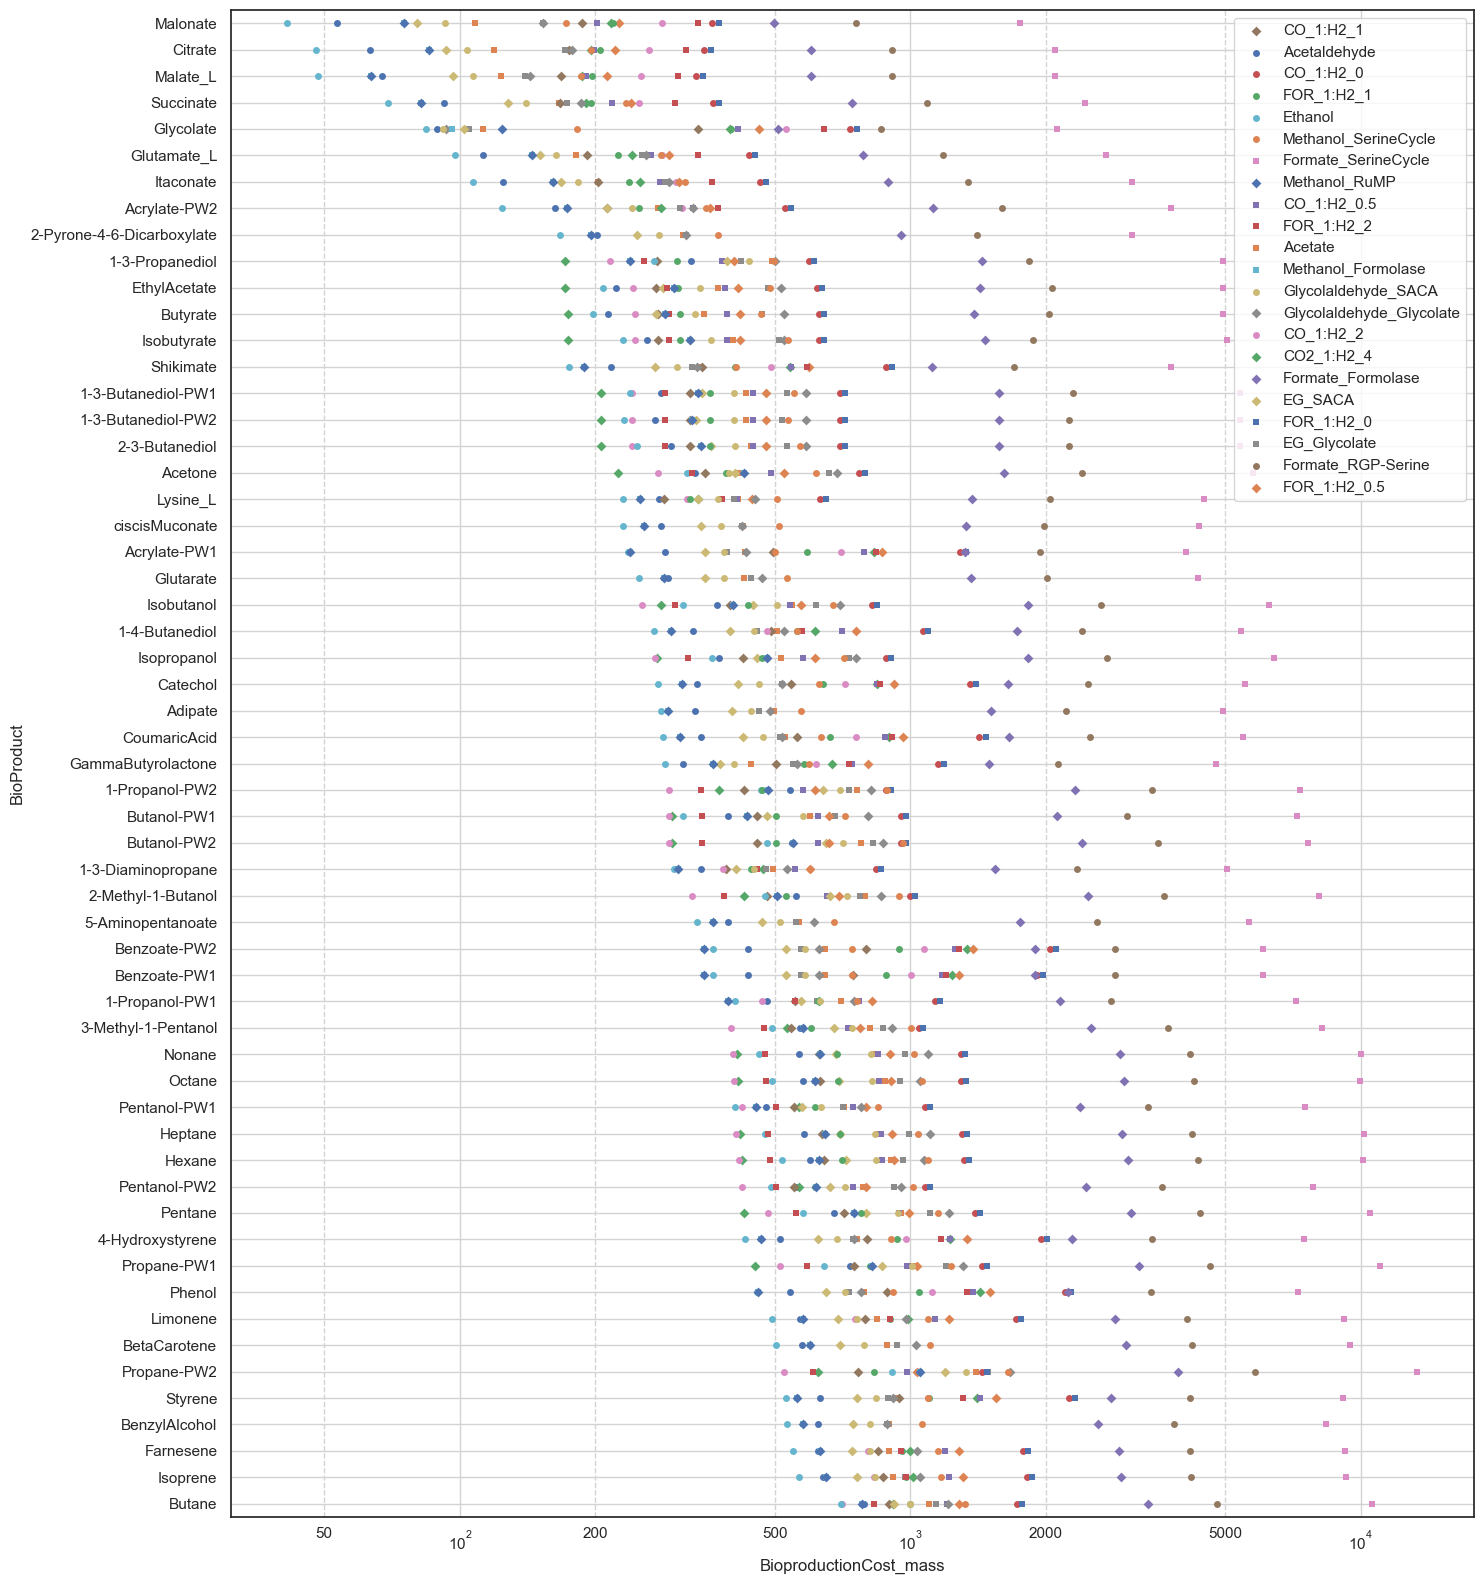

In [39]:
## -- For Graphing (Austin) -- ##

import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
data = biodata
biodata_sortbysubstrate = biodata.sort_values(by = 'SubstratePathway')
substrateset = biodata_sortbysubstrate.drop_duplicates(subset=['SubstratePathway'])['SubstratePathway'].tolist()

biodatasort = biodata.sort_values(by = 'BioproductionCost_mass')
mintomax = biodatasort.drop_duplicates(subset=['BioProduct'])
y_order = mintomax['BioProduct'].tolist()

biodata_sortedbyproduct =  biodata.sort_values(by='BioProduct', ascending=True)

sns.set_theme()
sns.set_style("white")


# Create a single subplot
fig, ax = plt.subplots(figsize=(15, 16))

# Define marker styles for each variable
marker_styles = ['o','s','D']

# Create the strip plot for each variable
for i, substrate in enumerate(substrateset):
    sns.stripplot(x="BioproductionCost_mass", y="BioProduct", data=biodata[biodata['SubstratePathway']==substrateset[i]], ax=ax,order=y_order, jitter=False, dodge=True,
                  marker=marker_styles[i%3], label = substrateset[i])

plt.xscale('log')
ax.grid(which = "major",color='lightgray', linestyle='-', linewidth=1)
ax.grid(which = "minor",color='lightgray', linestyle='--', linewidth=1)

ax.tick_params(which = "minor", bottom = False, left = False)

import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator

ax.xaxis.set_minor_formatter(ticker.ScalarFormatter())
ax.xaxis.set_major_locator(LogLocator(base=10))
ax.xaxis.set_minor_locator(LogLocator(base=10,subs=[2.0,5.0]))

# Create a legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
legend_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(legend_handles, unique_labels,loc='upper right')


plt.tight_layout()
plt.savefig("biodata_best.svg", format='svg') #change file name based on case

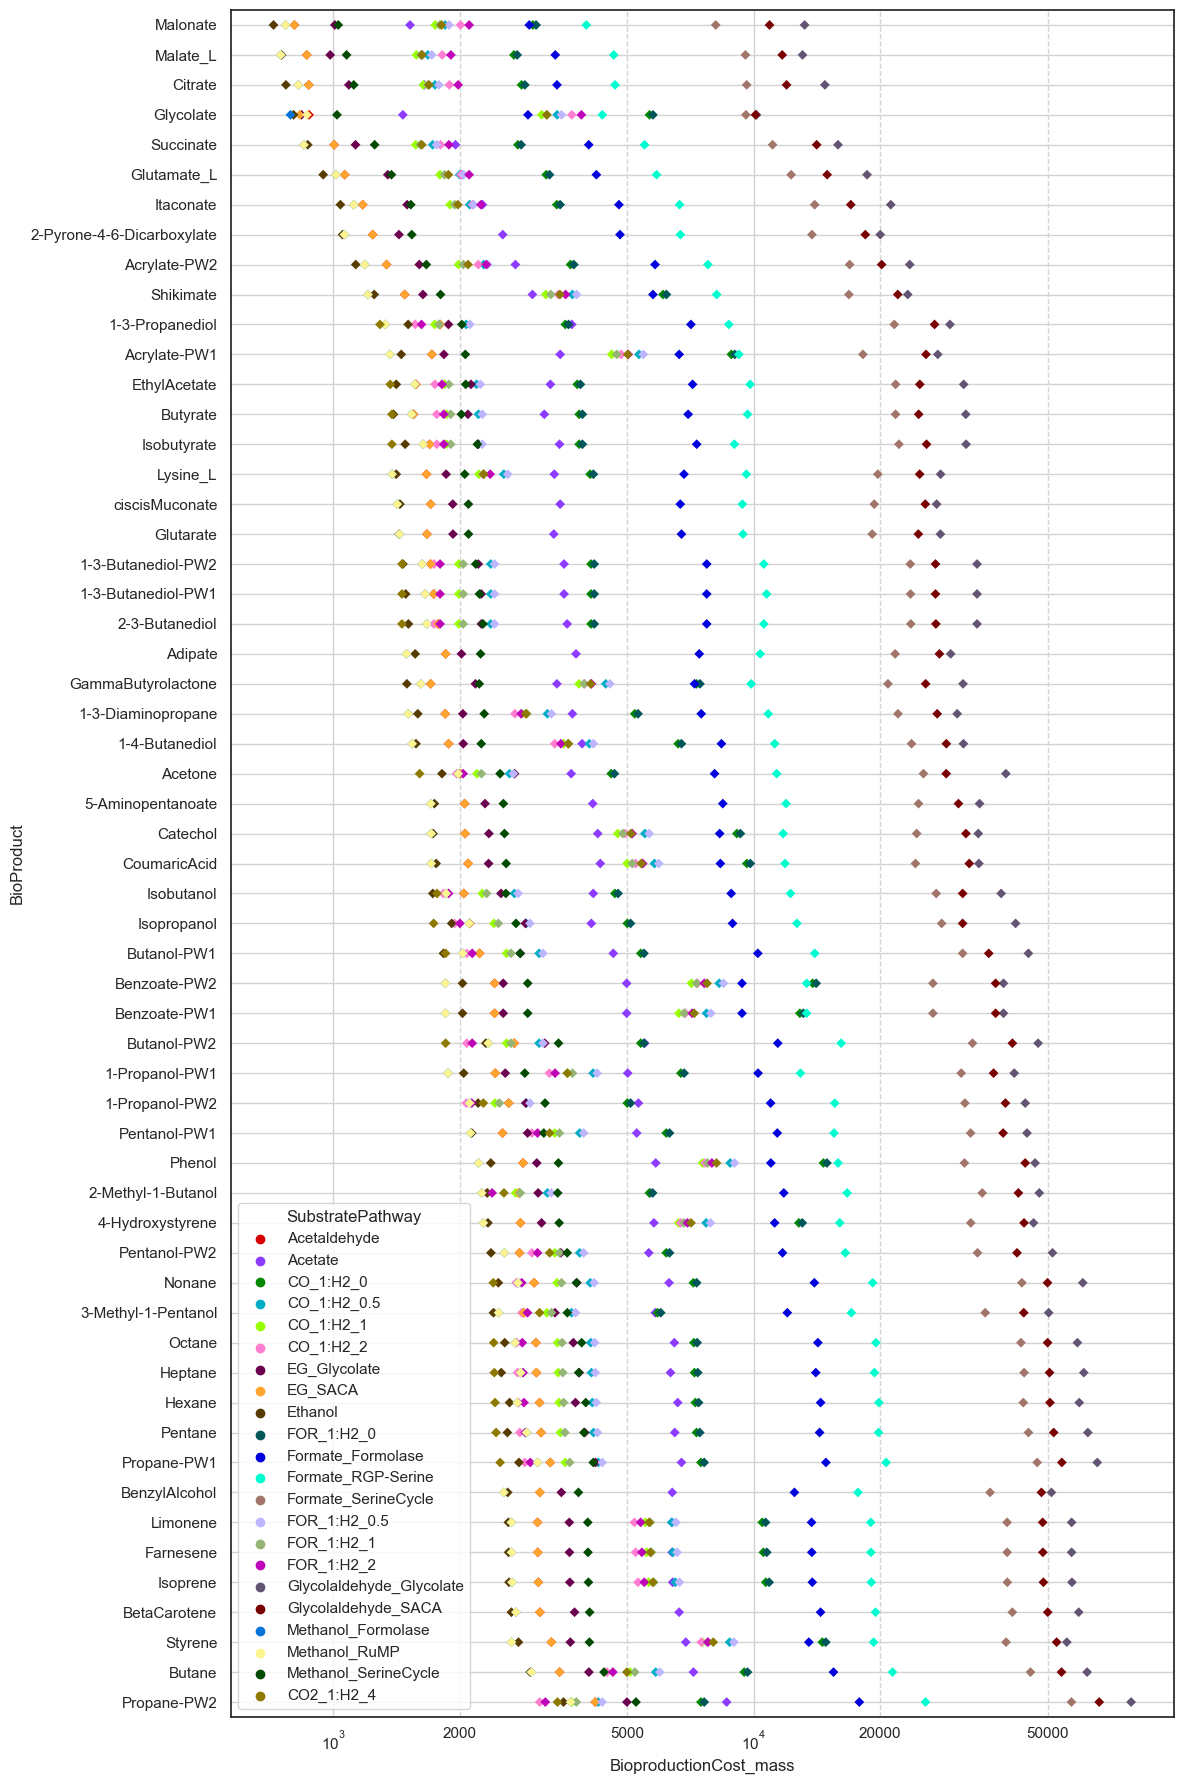

In [51]:
## -- For Graphing (Austin) -- old ##


biodatasort = biodata.sort_values(by = 'BioproductionCost_mass')
mintomax = biodatasort.drop_duplicates(subset=['BioProduct'])
y_order = mintomax['BioProduct'].tolist()

biodata_sortedbyproduct =  biodata.sort_values(by='BioProduct', ascending=True)

sns.set_theme()
sns.set_style("white")

from matplotlib import rcParams
rcParams['figure.figsize'] = 12,18

palette = sns.color_palette(cc.glasbey, n_colors=len(biodatasort.drop_duplicates(subset=['SubstratePathway'])))

ax = sns.stripplot(data=biodata, x="BioproductionCost_mass", y="BioProduct",hue="SubstratePathway", order=y_order, jitter=False, palette=palette, marker="D")
#ax = sns.swarmplot(data=biodata, x="BioproductionCost_mass", y="BioProduct",hue="SubstratePathway", order=y_order, palette=palette, size=4)
plt.xscale('log')
ax.grid(which = "major",color='lightgray', linestyle='-', linewidth=1)
ax.grid(which = "minor",color='lightgray', linestyle='--', linewidth=1)

ax.tick_params(which = "minor", bottom = False, left = False)

import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator

ax.xaxis.set_minor_formatter(ticker.ScalarFormatter())
ax.xaxis.set_major_locator(LogLocator(base=10))
ax.xaxis.set_minor_locator(LogLocator(base=10,subs=[2.0,5.0]))

plt.tight_layout()
plt.savefig("biodata_base2.svg", format='svg') #change file name based on case




# ECR Product Calculations #
The functions/code in the sections below can be used to calculate the production costs for ECR products (ECR production alone and/or hybrid system) - everything except CO2/H2 mixtures, which are calculated in another section further below.

## A - Import Data ##

In [3]:
#Import ECR Data
def ecrParameterData(case, analysisType, ECRfileName):
    
    #Read product-based ECR parameters into dataframe
    #fileName = 'ECR_Parameters.xlsx'
    
    if analysisType is 'Categories':
        if case is 'Category_1':
            sheetName = 'Parameters_CATEGORY1'
        elif case is 'Category_2':
            sheetName = 'Parameters_CATEGORY2'
        else:
            print('ecrParameterData function is not set up to specify parameter values for this case. Assuming category 1 values.')
            sheetName = 'Parameters_CATEGORY1'
    
    #========== Older scenarios===========#
    elif analysisType is 'Ideal':
        if case is 'Base':
            sheetName = 'ParametersIdeal_BASE'
        elif case is 'Best':
            sheetName = 'ParametersIdeal_BEST'
        else:
            print('ecrParameterData function is not set up to specify V, CD, FE, and byproduct values for this kind of case. Assuming base case values.')
            sheetName = 'ParametersIdeal_BASE'
            
    elif analysisType is 'Realistic':
        sheetName = 'ParametersRealistic'
    
    #======================================#
    
    else: 
        sheetName = 'Category_1'
        print('Invalid analysis type. Category 1 values assumed for analysis.')
        
    parameterDF = pd.read_excel(inputDirectory_general + ECRfileName, sheet_name=sheetName)
    #display(parameterDF) #Check
    parameterDF = parameterDF.drop(columns = ['Source'], errors='ignore') #Errors = ignore used to prevent error message if "Source" column doesn't exist
    
    #Read product data into dataframe
    productDF = pd.read_excel(inputDirectory_general + ECRfileName, sheet_name='Products')
    #display(productDF) #Check
    
    #Merge the two dataframes based on the products in the parameterDF
    parameterDF = parameterDF.merge(productDF, 'inner', 'SubstrateName')
    #print('parameterDF after product merge:')#Check
    #display(parameterDF) #Check
    
    #Electrolyzer Price (base case) based on Jouny (2018) paper
    ElectrolyzerPrice_base = ((((175)*(10**4)/(10**3)*(1.75)/(10**3))*1.2*250)/0.65)/0.78 #=1812
    #[kW/m^2] = ((mA/cm^2)*(10^4 cm^2/m^2)*(1A/10^3mA)*(V)*(1 kW/10^3 W))*1.2 (for capital investment)-->  A*V =W
    #[$US/m^2] = (kW/m^2)*(250$/kW)
    #[$CA/m^2] = ($US/m^2)*(1$CA/ 0.78 $US)
    #  --> /0.65 takes into account the Balance of plant costs too (which account for 35% of total capital costs, where capital costs = installed cost of electrolyzer+BoP)

    #Add product-independent parameter data (based on specified case)
    #CO2 price: Worst: 140, base: 100, best: 55 $CAD/tonne 
    #Electricity price:  Worst: 10C/kWh, Base: 4C/kWh, Best: 2C/kWh **Trying a very low best just in case...
    if case is 'Category_1' or 'Category_2' or 'Category_3':
        parameterDF['ElectricityPrice'] =(2.5+4)/2/100 #Ranges from 2.5-4 cents/kWh, converted to $/kWh here
        parameterDF['CO2Price'] = (55+100)/2 #Ranges from 55 to 100 $/tonne
        parameterDF['CarbonTax'] = 170 #50
        parameterDF['ElectrolyzerPrice'] = ElectrolyzerPrice_base #$CAD/m^2 ($US*$CAD/$US)
        parameterDF['PlantLife'] = 20 #Years
        parameterDF['StreamFactor'] = 0.95
        parameterDF['Bioconversion'] = 90
        parameterDF['ParametersType'] = analysisType + '-' + case
    
    
    #========== Older scenarios===========#
    elif case is 'Worst':
         
        parameterDF['ElectricityPrice'] =8/100 #3/100
        parameterDF['CO2Price'] = 140
        parameterDF['CarbonTax'] = 170 #50
        parameterDF['Conversion'] =  50
        parameterDF['ElectrolyzerPrice'] = ElectrolyzerPrice_base*1.3 #$CAD/m^2 ($US*$CAD/$US)
        parameterDF['PlantLife'] = 20 #Years
        parameterDF['StreamFactor'] = 0.95
        parameterDF['Bioconversion'] = 90
        parameterDF['ParametersType'] = analysisType + '-' + case
        
    elif case is 'Best':
         
        parameterDF['ElectricityPrice'] = 2.5/100 #1/100
        parameterDF['CO2Price'] = 55
        parameterDF['CarbonTax'] = 170
        parameterDF['Conversion'] = 60
        parameterDF['ElectrolyzerPrice'] = 1500 #ElectrolyzerPrice_base*0.7 #$CAD/m^2 ($US*$CAD/$US)
        parameterDF['PlantLife'] = 20 #Years
        parameterDF['StreamFactor'] = 0.95
        parameterDF['Bioconversion'] = 90
        parameterDF['ParametersType'] = analysisType + '-' + case
    
    elif case is 'Base': #Assumes case is "Base" otherwise, or wrong input given in which case Base case is assumed
         
        parameterDF['ElectricityPrice'] = 4/100 #2/100
        parameterDF['CO2Price'] = 100
        parameterDF['CarbonTax'] = 170 #100
        parameterDF['Conversion'] = 50
        parameterDF['ElectrolyzerPrice'] = ElectrolyzerPrice_base #$CAD/m^2
        parameterDF['PlantLife'] = 20 #Years
        parameterDF['StreamFactor'] = 0.95
        parameterDF['Bioconversion'] = 80
        parameterDF['ParametersType'] = analysisType + '-' + case
        
    #======================================#    
        
    else: 
        parameterDF['ElectricityPrice'] =(2.5+4)/2/100 #Ranges from 2.5-4 cents/kWh, converted to $/kWh here
        parameterDF['CO2Price'] = (55+100)/2 #Ranges from 55 to 100 $/tonne
        parameterDF['CarbonTax'] = 170 #50
        parameterDF['ElectrolyzerPrice'] = ElectrolyzerPrice_base #$CAD/m^2 ($US*$CAD/$US)
        parameterDF['PlantLife'] = 20 #Years
        parameterDF['StreamFactor'] = 0.95
        parameterDF['Bioconversion'] = 90
        parameterDF['ParametersType'] = analysisType + '-' + case
        
        tempDF = parameterDF[['ElectricityPrice', 'CO2Price', 'CarbonTax', 'ElectrolyzerPrice', 'PlantLife','StreamFactor', 'Bioconversion', 'ParametersType']]
        print ('Invalid case type specified. Values assumed:')
        display(tempDF)
        
    #print("The Electrolyzer Price is:", str(parameterDF['ElectrolyzerPrice'])) #Check
    
    parameterDF = parameterDF.rename(columns={"SubstrateName": "Substrate", "Formula":"Formula_S", "C_n": "C_Sn", "H_n": "H_Sn", "O_n":"O_Sn"})
    parameterDF = parameterDF[['Substrate', 'SubstrateType', 'Tier', 'Formula_S', 'C_Sn', 'H_Sn', 'O_Sn', 'H2Ratio', 'MW_S', 
                               'N_electrons', 'ParametersType', 'CellVoltage', 'CurrentDensity','FaradaicEfficiency', 
                               'EnergyEfficiency', 'ByProducts', 'ByP_FE', 'Xco2','ElectricityPrice', 
                               'CO2Price', 'CarbonTax', 'Conversion', 'ElectrolyzerPrice', 'PlantLife', 
                               'StreamFactor', 'Bioconversion', 'ScalingFactor' ]]
    
    #Units
    units = {'Substrate': '-',
        'SubstrateType': 'None',
        'Formula_S': 'None',
        'C_Sn': '#',
        'H_Sn': '#',
        'O_Sn': '#',
        'MW_S': 'g/mol', 
        'N_electrons': 'e-/mole',
        'ParametersType': 'Case set',
        'CellVoltage':  'V',
        'CurrentDensity': 'mA/cm^2',
        'FaradaicEfficiency': '%',
        'EnergyEfficiency': '%',
        'ByProducts': 'None',
        'ByP_FE': '%',
        'Xco2': 'mol CO2/mol e-',
        'ElectricityPrice': '$/kWh',
        'CO2Price': '$/tonne',
        'CarbonTax': '$/tonne',
        'Conversion': '%',
        'ElectrolyzerPrice': '$CAD/m^2',
        'PlantLife': 'Years',
        'StreamFactor': 'days operated per year/365',
        'Bioconversion': '%',
        'ScalingFactor': 'x'
        } #Dictionary of units
    
    #print('Final parameterDF:')
    #display(parameterDF)
    #display(units)
    
    return (parameterDF,units)

#Test:
#results = ecrParameterData('Base', 'Ideal', ECRfileName)
#ECR_df=results[0]
#display(ECR_df)

<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:26: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:58: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:70: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:94: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: Synta

In [4]:
#Import Bioconversion Data
#Only need to run when performing hybrid system calculations

def importBioconversionData(FBAfileName, PathwaysfileName):

    #Read bioproduct properties from Excel file
    BP1_df = pd.read_excel(inputDirectory_general + FBAfileName, sheet_name='Overall Results')
    BP1_df['CO2_BProd_molar'] = BP1_df['CO2_Flux']/BP1_df['Obj_Flux'] #[mol CO2/mol P] = (mmolCO2/gDW-h)*(gDW-h/mmolP)
    BP1_df['CO2_BProd_mass'] = BP1_df['CO2_BProd_molar']/BP1_df['MW_g/mol_P']*44.01 #[tonne CO2/tonne P] = (molCO2/molP)*(molP/gP)*(gCO2/molCO2)
    #BP1_df['CO2_YieldBP_Mass'].replace({math.inf: 0}, inplace=True)#Where CO2 flux=0, value will be infinite; replace with 0
    #Negative CO2 BProd (bioproduced) indicates that CO2 is consumed in bioconversion stage vs positive indicates it's produced
    
    #print('BP1_df')
    #display(BP1_df) #Check
    BP2_df = BP1_df [['Substrate', 'Product', 'Formula_P', 'MW_g/mol_P', 'Deg_Red_P', 'BP_degC_P', 'CO2_BProd_mass', 'Yield_Molar', 'Yield_Mass','isLiq','isGas','Conc','LH']]
    BP2_df = BP2_df.rename(columns={"Substrate": "SubstratePathway","Product": "BioProduct", "Formula_P": "Formula_BP", "MW_g/mol_P": "MW_BP", "Deg_Red_P": "Deg_RedBP",\
                                    "BP_degC_P": "BoilP_degC", "Yield_Molar": "YieldBP_Molar", "Yield_Mass": "YieldBP_Mass","isLiq":"Liquid","isGas":"Gas","Conc":"Conc_Product","LH": "Latent_Heat"})
    #print('BP2_df')
    #display(BP2_df) #Check
    
    #Read pathway and substrate names from Excel file
    PW_df = pd.read_excel(inputDirectory_general + PathwaysfileName, sheet_name='Assimilation Pathways')
    #print('PW_df')
    #display(PW_df) #Check
    
    #Merge two DFs above
    BP3_df = BP2_df.merge(PW_df, 'inner', 'SubstratePathway')
    BP3_df = BP3_df [['Substrate', 'SubstratePathway', 'BioProduct', 'Formula_BP', 'MW_BP', 
                      'Deg_RedBP', 'BoilP_degC', 'CO2_BProd_mass', 'YieldBP_Molar', 'YieldBP_Mass','Liquid','Gas','Conc_Product','Latent_Heat']]
    #print('BP3_df')
    #display(BP3_df) #Check

    #Units
    units = {'Substrate': '-',
            'SubstratePathway':  '-',
            'BioProduct': '-',
            'Formula_BP': '-',
            'MW_BP': 'g/mol',
            'Deg_RedBP': '-',
            'BoilP_degC': 'deg C',
            'CO2_BProd_mass': 'tonneCO2/tonneBP; -ve=consumed, +ve=produced',
            'YieldBP_Molar': 'mol/mol or gDW/mmol (biomass)',
            'YieldBP_Mass': 'g/g',
            'Liquid': '-',
            'Gas': '-',
            'Conc_Product': 'kg/litre (liq) or kg/m3_headspace (gas)',
            'Latent_Heat': 'kJ/mol'             
            }#Dictionary of units         
    #display(units) #Check
             
             
    #BP_df = pd.read_csv(folderPath + bioproductDataFile)
    #BP_df = BP_df.rename(columns={'Name': 'Bioproduct', 'Formula': 'Formula_BP', 'LHV': 'LHV_BP', 'HHV': 'HHV_BP' })
                                        
    #Units
    #unitsBP = {'Bioproduct_Name':  'None',
           # 'Formula': 'None',
            #'MW_BP': 'g/mol',
            #'LHV': 'MJ/tonne',
            #'HHV': 'MJ/tonne'
            #}#Dictionary of units

    
    return(BP3_df, units)

#Test:
results = importBioconversionData(FBAfileName, PathwaysfileName)
BP_df = results[0]
display(BP_df)

,Substrate,SubstratePathway,BioProduct,Formula_BP,MW_BP,Deg_RedBP,BoilP_degC,CO2_BProd_mass,YieldBP_Molar,YieldBP_Mass,Liquid,Gas,Conc_Product,Latent_Heat
0,Acetaldehyde,Acetaldehyde,1-3-Butanediol-PW1,C4H10O2,90.11920,5.500000,207,0.279667,0.437381,0.894775,1,0,0.12,72.60
1,Acetaldehyde,Acetaldehyde,1-3-Butanediol-PW2,C4H10O2,90.11920,5.500000,207,0.242319,0.444821,0.909995,1,0,0.12,72.60
2,Acetaldehyde,Acetaldehyde,1-3-Diaminopropane,C3H12N2,76.13958,6.000000,139.3,0.594379,0.496486,0.858133,1,0,0.12,50.18
3,Acetaldehyde,Acetaldehyde,1-3-Propanediol,C3H8O2,76.09282,5.333333,213,0.529093,0.510882,0.882473,1,0,0.12,70.00
4,Acetaldehyde,Acetaldehyde,1-4-Butanediol,C4H10O2,90.11920,5.500000,230,0.464456,0.403953,0.826391,1,0,0.12,78.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,Xylose,Xylose,Propane-PW1,C3H8,44.09482,6.666667,-42,2.308627,0.941074,0.276404,0,1,0.12,0.00
1308,Xylose,Xylose,Propane-PW2,C3H8,44.09482,6.666667,-42,3.371157,0.783987,0.230266,0,1,0.12,0.00
1309,Xylose,Xylose,Shikimate,C7H9O5,173.14046,3.857143,400.5,0.133469,0.664444,0.766284,1,0,0.12,40.65
1310,Xylose,Xylose,Styrene,C8H8,104.14832,5.000000,145,1.218875,0.459372,0.318676,1,0,0.12,43.90


In [5]:
#Merges ECR and Bioproduction data; only need to run if performing hybrid calculations
def mergeData(BP_df, ECR_df):
    
    dataDF = BP_df.merge(ECR_df, 'inner', 'Substrate')
    dataDF = dataDF[['Substrate','SubstrateType', 'Formula_S', 'C_Sn', 'H_Sn', 'O_Sn', 'MW_S', 
                        'N_electrons', 'ParametersType', 'CellVoltage', 'CurrentDensity','FaradaicEfficiency', 
                        'EnergyEfficiency', 'ByProducts', 'ByP_FE', 'Xco2','ElectricityPrice', 
                        'CO2Price', 'CarbonTax', 'Conversion', 'ElectrolyzerPrice', 'PlantLife', 
                        'StreamFactor', 'Bioconversion', 'ScalingFactor',
                        'SubstratePathway', 'BioProduct', 'Formula_BP', 'MW_BP', 'Deg_RedBP', 'BoilP_degC', 
                        'CO2_BProd_mass', 'YieldBP_Molar', 'YieldBP_Mass','Liquid','Gas','Conc_Product','Latent_Heat']]
    #print('dataDF:')
    #display(dataDF) #Check
    
    #Units
    units = {'Substrate': '-',
        'SubstrateType': 'None',
        'Formula_S': 'None',
        'C_Sn': '#',
        'H_Sn': '#',
        'O_Sn': '#',
        'MW_S': 'g/mol', 
        'N_electrons': 'e-/mole',
        'ParametersType': 'Case set',
        'CellVoltage':  'V',
        'CurrentDensity': 'mA/cm^2',
        'FaradaicEfficiency': '%',
        'EnergyEfficiency': '%',
        'ByProducts': 'None',
        'ByP_FE': '%',
        'Xco2': 'mol CO2/mol e-',
        'ElectricityPrice': '$/kWh',
        'CO2Price': '$/tonne',
        'CarbonTax': '$/tonne',
        'Conversion': '%',
        'ElectrolyzerPrice': '$CAD/m^2',
        'PlantLife': 'Years',
        'StreamFactor': 'days operated per year/365',
        'Bioconversion': '%',    
        'ScalingFactor': 'x',
        'SubstratePathway':  '-',
        'BioProduct': '-',
        'Formula_BP': '-',
        'MW_BP': 'g/mol',
        'Deg_RedBP': '-',
        'BoilP_degC': 'deg C',
        'CO2_BProd_mass': 'tonneCO2/tonneBP; -ve=consumed, +ve=produced',    
        'YieldBP_Molar': 'mol/mol or gDW/mmol (biomass)',
        'YieldBP_Mass': 'g/g',
        'Liquid': '-',
        'Gas': '-',
        'Conc_Product': 'kg/litre (liq) or kg/m3_headspace (gas)',
        'Latent_Heat': 'kJ/mol'  
        } #Dictionary of units
    #display(units) #Check
    
    return(dataDF, units)

#Test:
#results = mergeData(BP_df, ECR_df)
#dataDF = results[0]
#display(dataDF)
#display(results[1])

## B - Calculations ##

In [6]:
def calculateElectricityCosts(dataDF, rate, productionRate, electrodeArea):

    #Passed electrodeArea is in m^2, convert to cm^2 for calculations:
    electrodeArea = electrodeArea*10**4 #(area cm^2 = area m^2 * (10^4 cm^2/m^2))

    #Faraday constant:
    F = 96485.3329 #A*s/mol e-

    results = dataDF.copy()
    #print('results dataframe before calculations:')
    #display(results) #Check
    
    display(rate)
    if rate:
        #Determine Electrode Area (cm^2)
        if productionRate[1] is 'ECR': #If 'ECR', value is an ECR production rate
            results['ActualProductionRate'] = productionRate[0]*10**6/results['MW_S'] #Actual amount of product produced [mol SP/h] = (tonnes SP/h)*(10^6g SP/tonneSP)*(mol SP/g SP) 
        elif productionRate[1] is 'Bio': #If 'Bio', value is a bioproduction Rate
            results['ActualProductionRate'] = productionRate[0]*10**6/results['YieldBP_Mass']/results['MW_S']    #Actual amount of product produced [mol SP/h] = (tonnes BP/h)*(10^6g BP/tonneBP)*(g SP/g BP)*(mol SP/g SP)
            
            #Determine Cost of Electricity for Separation
            kWh_sep = []
            Cost_h_sep = []
            Type_sep = []
            for i in range(dataDF.shape[0]):
                if dataDF.iat[i, dataDF.columns.get_loc('Liquid')] == 1:
                    kWh_sep.append(0)
                    if dataDF.iat[i,dataDF.columns.get_loc('Latent_Heat')] < 30: #Can use distillation
                        Cost_h_sep.append(productionRate[0]/dataDF.iat[i,dataDF.columns.get_loc('Conc_Product')]*1000/60*DistPrice/1000)
                        #Cost = (tonnes Prod/hr)*(litre/kg Prod)*(1000 kg/tonne)*(1 hr/60 min)*($/hr for 1000L/min)
                        Type_sep.append('Distillation')
                    else: 
                        Cost_h_sep.append(productionRate[0]/dataDF.iat[i,dataDF.columns.get_loc('Conc_Product')]*1000*NFPrice)
                        #Cost = (tonnes Prod/hr)*(litre/kg Prod)*(1000 kg/tonne)*($/L)
                        Type_sep.append('Nanofiltration')
                else:
                    kWh_sep.append(productionRate[0]/dataDF.iat[i,dataDF.columns.get_loc('Conc_Product')]*1000*(dataDF.iat[i,dataDF.columns.get_loc('Gas')]*PSAPrice))
                    #Electricity needed in 1h [kWh] = (tonnes P/hr)*(m3/kg P)*(1000 kg/tonne)*(kWh/m3 for gas or kWh/litre for liquid)
                    Cost_h_sep.append(kWh_sep[i]*dataDF.iat[i,dataDF.columns.get_loc('ElectricityPrice')]) #Electricity cost [$/h] = (kWh for 1h)*($/kWh)
                    Type_sep.append('PSA')
            results['kWh_sep'] = kWh_sep
            results['Cost_h_sep'] = Cost_h_sep
            results['Type_sep'] = Type_sep
        else: 
            print('Invalid type of production rate. ECR rate assumed for analysis.')
            results['ActualProductionRate'] = productionRate[0]
        
        results['MaxProductionRate'] = results['ActualProductionRate']/(results['FaradaicEfficiency']/100) #Max production rate if all electrons go to production [molP/h] = (actual molP/h)/(%FE)
        results['emol_curr'] = results['MaxProductionRate']*results['N_electrons']/3600 #[mol e-/s] = (molP/h)*(mol e-/mol P)*(1h/3600s)
        results['I'] = results['emol_curr']*F #[A] = (mol e-/s)*(A*s/mol e-)
        results['ElectrodeArea'] = results['I']/results['CurrentDensity']*1000 #[cm^2] = (A)*(cm^2/mA)*(10^3 mA/A)
        
        #Determine Cost of Electricity Needed ($/h)
        results['Power'] = results['I']*results['CellVoltage'] #power [W] = (A*V)
        results['kWh'] = results['Power']*1/1000 #Electricity needed in 1h [kWh]
        results['Cost_elec_h'] = results['kWh']*results['ElectricityPrice'] #Electricity cost [$/h] = (kWh for 1h)*($/kWh)
        
    
    else:
        #Determine Cost of Electricity Needed($/h)
        results['ElectrodeArea'] = electrodeArea
        results['I'] = results['CurrentDensity']*results['ElectrodeArea']/1000 #current [A] = (mA/cm^2)*(cm^2)*(A/1000mA)
        results['Power'] = results['I']*results['CellVoltage'] #power [W] = (A*V)
        results['kWh'] = results['Power']*1/1000 #Electricity needed in 1h [kWh]
        results['Cost_elec_h'] = results['kWh']*results['ElectricityPrice'] #Electricity cost [$/h] = (kWh for 1h)*($/kWh)
        

        #Determine Production Rate (mol/h)
        results['emol_curr'] = results['I']/F #Moles of electrons per second in current [mol e-/s] = (A)*(mol e-/A*s)
        results['MaxProductionRate'] = results['emol_curr']/results['N_electrons']*3600 #Max production rate if all electrons go to production [molP/h] = (mol e-/s in current)*(mol Prod/e-)*(3600s/h)
        results['ActualProductionRate'] = results['MaxProductionRate']*(results['FaradaicEfficiency']/100) #Actual amount of product produced [mol P/h] = (molP/h)*(%FE)


    #Determine Molar Cost of Electricity ($/mol)
    results['Cost_elec_mol'] = results['Cost_elec_h']/results['ActualProductionRate'] #Molar cost of electricity [$/molP] = ($/h)*(h/molP)

    #Determine Cost of CO2 Needed
    results['CO2rate_conv'] = 3600*results['I']/F*results['Xco2']*44.01/10**6 #[tonnes/h]= (3600s/h)(A)(mol e-/A*s)*(mol CO2/mol e-)*(g CO2/molCO2)*(1 tonne/10^6g)
    results['CO2rate_fed'] = results['CO2rate_conv']/(results['Conversion']/100) #tonnes CO2/h
    results['Cost_CO2_h'] = results['CO2Price']*results['CO2rate_fed'] #Molar CO2 cost [$/h] = ($/tonne)*(tonne CO2/h)

    
    #Determine Electrolyzer Cost
    #[$/h] = ($/m^2)*(cm^2)*(m^2/10^4cm^2)*(1/plant life years)*(1 year/365 days)*(1 day/24h)/0.95
    #--> 0.95 is stream factor
    results['Cost_electrolyzer_h'] = results['ElectrolyzerPrice']*(results['ElectrodeArea']/10**4)/results['PlantLife']*(1/365)*(1/24)/0.95
    results['Cost_electrolyzer_mol'] = results['Cost_electrolyzer_h']/results['ActualProductionRate'] #[$/mol]=($/h)*(h/mol)
    
    #Carbon Tax Savings
    results['CT_savings_h'] = results['CarbonTax']*results['CO2rate_conv'] #Molar CO2 savings [$/h] = ($/tonne)*(tonne/h)
    #The carbon tax savings are calculated based on the CO2 converted, which includes CO2 conversion to by-products
    #print("Carbon tax savings ($/h):", CT_savings_h)
    
    
    #Convert Costs to Mass-basis
    results['Cost_elec_mass'] = results['Cost_elec_mol']/results['MW_S']*10**6 #Mass based electricity cost [$/tonne]=($/mol)*(mol/g)*(10^6 g/tonne)
    results['Cost_CO2_mass'] = results['Cost_CO2_h']/results['ActualProductionRate']/results['MW_S']*10**6 #Mass based CO2 costs [$/tonne]=($/h)*(h/mol)*(mol/g)*(10^6 g/tonne)
    results['Cost_electrolyzer_mass'] = results['Cost_electrolyzer_mol']/results['MW_S']*10**6 #[$/tonne]=($/molP)*(molP/gP)*(10^6g/1 tonne)
    results['CT_savings_mass'] = results['CT_savings_h']/results['ActualProductionRate']/results['MW_S']*10**6 #Mass based carbon savings [$/tonne]=($/h)*(h/mol)*(mol/g)*(10^3 g/tonne)
    results['ActualProductionRate_mass'] = results['ActualProductionRate']*results['MW_S']/10**6 #[tonne P/h]: (mol P/h)(gP/mol)*(1 tonne/10^6g)

    
    #Total Production Costs
    if productionRate[1] is 'Bio':
        results['ProductionCost_hNOCT']= (results['Cost_elec_h'] + results['Cost_CO2_h']+results['Cost_electrolyzer_h']+results['Cost_h_sep'])*results['ScalingFactor'] #Hourly cost of production [$/h], without carbon tax savings
    else:
        results['ProductionCost_hNOCT']= (results['Cost_elec_h'] + results['Cost_CO2_h']+results['Cost_electrolyzer_h'])*results['ScalingFactor'] #Hourly cost of production [$/h], without carbon tax savings
    results['ProductionCost_massNOCT'] = results['ProductionCost_hNOCT']/results['ActualProductionRate']/results['MW_S']*10**6 #Mass cost of production [$/tonne]=($/h)*(h/mol)*(mol/g)*(10^6 g/tonne)
    results['ProductionCost_h'] =  results['ProductionCost_hNOCT']-results['CT_savings_h'] #Hourly cost of production [$/h] = ($/h)-($/h)
    results['ProductionCost_mass'] = results['ProductionCost_massNOCT']-results['CT_savings_mass'] #Mass cost of production [$/tonne]=($/tonne)-($/tonne)
    
    
    #Calculation modifications for CO/H2 and Formate/H2 mixtures
    #To convert $/(tonne pure substrate) to $/(tonne mixture), the following equation is used:
    #[$/tonne mix] = ($/tonne S)*(mol S/mol mix)*(mol mix/g mix)*(g S/ mol S)
    # = ($/tonne S)*(g S/g Mix) = ($/tonne S)*(tonne S/tonne Mix)
    #Where FaradaicEfficiency/100 gives (mol S/mol mix)
    results.loc[results['SubstrateType'] == 'Mix', 'MW_mix'] = results['FaradaicEfficiency']/100*results['MW_S']+(1-results['FaradaicEfficiency']/100)*2.02 #[g mix/mol mix] = (mol S/mol mix)*(g S/mol S)+(mol H2/mol mix)*(g H2/mol H2)
    results.loc[results['SubstrateType'] == 'Mix', 'Cost_elec_mass'] = results['Cost_elec_mass']*(results['FaradaicEfficiency']/100)/results['MW_mix']*results['MW_S']
    results.loc[results['SubstrateType'] == 'Mix', 'Cost_CO2_mass'] = results['Cost_CO2_mass']*(results['FaradaicEfficiency']/100)/results['MW_mix']*results['MW_S']
    results.loc[results['SubstrateType'] == 'Mix', 'Cost_electrolyzer_mass'] = results['Cost_electrolyzer_mass']*(results['FaradaicEfficiency']/100)/results['MW_mix']*results['MW_S']
    results.loc[results['SubstrateType'] == 'Mix', 'CT_savings_mass'] = results['CT_savings_mass']*(results['FaradaicEfficiency']/100)/results['MW_mix']*results['MW_S']
    results.loc[results['SubstrateType'] == 'Mix', 'ProductionCost_massNOCT'] = results['ProductionCost_massNOCT']*(results['FaradaicEfficiency']/100)/results['MW_mix']*results['MW_S']
    results.loc[results['SubstrateType'] == 'Mix', 'ProductionCost_mass'] = results['ProductionCost_mass']*(results['FaradaicEfficiency']/100)/results['MW_mix']*results['MW_S']
    
    #Convert electrodeArea back to m^2 for results table:
    results['ElectrodeArea'] = results['ElectrodeArea']/10**4 #(area m^2 = area cm^2* (1 m^2/10^4 cm^2))
    
    #**CO2 Consumed on Mass Basis:
    results['CO2_ECons_mass'] = results['CO2rate_conv']/results['ActualProductionRate_mass'] #tonneCO2/tonneSP = (tonneCO2/h)*(h/tonneSP)
    
    #print('Results dataframe after calculations:') #Check
    #display(results) #Check
    
    if productionRate[1] is 'ECR': #If 'ECR', value is an ECR production rate
        
            results = results[['Substrate', 'Formula_S', 'C_Sn', 'H_Sn', 'O_Sn', 'MW_S', 
                                'N_electrons', 'ParametersType', 'CellVoltage', 'CurrentDensity','FaradaicEfficiency', 
                                'EnergyEfficiency','ByProducts', 'ByP_FE', 'Xco2',
                                'ElectricityPrice','CO2Price', 'CarbonTax', 'Conversion',
                                'ElectrolyzerPrice', 'PlantLife', 'StreamFactor',
                                'ScalingFactor', 'ElectrodeArea', 'I', 'Power', 'kWh', 'emol_curr',
                                'MaxProductionRate', 'ActualProductionRate', 'ActualProductionRate_mass', 
                                'CO2rate_fed', 'CO2rate_conv', 'Cost_elec_h', 'Cost_CO2_h', 'Cost_electrolyzer_h',
                                'CT_savings_h', 'ProductionCost_hNOCT', 'ProductionCost_h', 'Cost_elec_mol',
                                'Cost_elec_mass', 'Cost_CO2_mass', 'Cost_electrolyzer_mass', 'CT_savings_mass',
                                'ProductionCost_massNOCT',  'ProductionCost_mass', 'CO2_ECons_mass'
                                ]]
    elif productionRate[1] is 'Bio': #If 'Bio', value is a bioproduction Rate

            results = results[['Substrate', 'Formula_S', 'C_Sn', 'H_Sn', 'O_Sn', 'MW_S', 
                                'N_electrons', 'ParametersType', 'CellVoltage', 'CurrentDensity','FaradaicEfficiency', 
                                'EnergyEfficiency','ByProducts', 'ByP_FE', 'Xco2',
                                'ElectricityPrice','CO2Price', 'CarbonTax', 'Conversion',
                                'ElectrolyzerPrice','PlantLife', 'StreamFactor', 
                                'ScalingFactor', 'ElectrodeArea', 'I', 'Power', 'kWh','kWh_sep','emol_curr',
                                'MaxProductionRate', 'ActualProductionRate', 'ActualProductionRate_mass', 
                                'CO2rate_fed', 'CO2rate_conv', 'Cost_elec_h','Cost_h_sep','Type_sep', 'Cost_CO2_h', 'Cost_electrolyzer_h',
                                'CT_savings_h','ProductionCost_hNOCT', 'ProductionCost_h','Cost_elec_mol', 
                                'Cost_elec_mass', 'Cost_CO2_mass', 'Cost_electrolyzer_mass', 'CT_savings_mass',
                                'ProductionCost_massNOCT',  'ProductionCost_mass', 'CO2_ECons_mass',
                                'BioProduct', 'Formula_BP', 'MW_BP', 'Deg_RedBP', 'BoilP_degC', 
                                'SubstratePathway','CO2_BProd_mass','YieldBP_Molar', 'YieldBP_Mass', 'Bioconversion'
                                ]]
            
            results['BioproductionCost_massNOCT'] = results['ProductionCost_massNOCT']/results['YieldBP_Mass']/(results['Bioconversion']/100)
            results['BioproductionCost_mass1'] = results['ProductionCost_mass']/results['YieldBP_Mass']/(results['Bioconversion']/100)
            #This was original bioproduct cost used (doesn't take into account the CO2 production/consumption in bioproduction stage)
            
            #Bioproduction cost below accounts for CO2 production/consumption in bioproduction stage:
            #Overall CO2 consumed on a mass basis (accounting for ECR step and bioproduction step)
            #(Overall CO2 consumed )= (CO2 consumed in ECR)-(CO2 produced in Bioproduction)
            #results['E'] = results['YieldBP_Mass']*results['Bioconversion']/100
            results['CO2_OverallCons_mass'] = results['CO2_ECons_mass']/(results['YieldBP_Mass']*results['Bioconversion']/100)-results['CO2_BProd_mass']
            #[tonne CO2/tonne BP] = (tonne CO2/tonne SP)*(tonne SP/tonne PB)-(tonne CO2/tonne BP)
            #Note: tonne SP/tonne BP takes into account bioyield and bioconversion (yield*conv)^-1
            results['CT_OverallSavings_mass'] = results['CO2_OverallCons_mass']*results['CarbonTax'] 
            #[$/tonne BP] = (tonne CO2/tonne BP)*($/tonne CO2)
            results['BioproductionCost_mass2'] = results['BioproductionCost_massNOCT']-results['CT_OverallSavings_mass']                                                     
            #[$/tonne BP] = ($costs/tonne BP)-($ savings/tonne BP)                                                            

    #Units
    units = {'Substrate': '-',
        'Formula_S': 'None',
        'C_Sn': '#',
        'H_Sn': '#',
        'O_Sn': '#',
        'MW_S': 'g/mol', 
        'N_electrons': 'e-/mole',
        'ParametersType': 'Case set',
        'CellVoltage':  'V',
        'CurrentDensity': 'mA/cm^2',
        'FaradaicEfficiency': '%',
        'EnergyEfficiency': '%',
        'ByProducts': 'None',
        'ByP_FE': '%',
        'Xco2': 'mol CO2/mol e-',
        'ElectricityPrice': '$/kWh',
        'CO2Price': '$/tonne',
        'CarbonTax': '$/tonne',
        'Conversion': '%',
        'ElectrolyzerPrice': '$CAD/m^2',
        'PlantLife': 'Years',
        'StreamFactor': 'days operated per year/365',
        'ScalingFactor': 'x',
        'ElectrodeArea': 'm^2',
        'I': 'Amp',
        'Power': 'W',
        'kWh': 'kWh',
        'emol_curr': 'mol e-/s in current',
        'MaxProductionRate': 'molP/h',    
        'ActualProductionRate': 'molP/h',
        'ActualProductionRate_mass': 'tonne P/h',
        'CO2rate_fed': 'tonne CO2/h',
        'CO2rate_conv': 'tonne CO2/h',      
        'Cost_elec_h': '$/h',
        'Cost_CO2_h': '$/h',
        'Cost_electrolyzer_h': '$/h',
        'CT_savings_h': '$/h',
        'ProductionCost_hNOCT': '$/h',
        'ProductionCost_h': '$/h',   
        'Cost_elec_mol': '$/mol SP',
        'Cost_elec_mass': '$/tonne SP OR $/tonne mix for mix',
        'Cost_CO2_mass': '$/tonne SP OR $/tonne mix for mix',
        'Cost_electrolyzer_mass': '$/tonne SP OR $/tonne mix for mix',
        'CT_savings_mass': '$ savings/tonne SP OR $/tonne mix for mix',  
        'ProductionCost_massNOCT': '$/tonne SP OR $/tonne mix for mix',
        'ProductionCost_mass': '$/tonne SP OR $/tonne mix for mix',
        'CO2_ECons_mass': 'tonne CO2 consumed/tonne SP',
        '****** If bioproduction considered too: ****': '',
        'BioProduct': '-',
        'Formula_BP': '-',
        'MW_BP': 'g/mol',
        'Deg_RedBP': '-',
        'BoilP_degC': 'deg C',
        'SubstratePathway':  '-',
        'CO2_BProd_mass': 'tonneCO2/tonneBP; -ve=consumed, +ve=produced',
        'YieldBP_Molar': 'mol/mol or gDW/mmol (biomass)',
        'YieldBP_Mass': 'g/g OR g/g mix for mix',
        'Bioconversion': '%',
        'BioproductionCost_massNOCT': '$/tonne BP',
        'BioproductionCost_mass1': '$/tonne BP',
        'CO2_OverallCons_mass': 'tonne CO2/tonne BP',
        'CT_OverallSavings_mass': '$ savings/tonne BP',
        'BioproductionCost_mass2': '$/tonne BP',
        'Conc_Product': 'kg/m3 if gas and kg/litre if liquid'
        }#Dictionary of units
    display(results) #Check
    return (results, units)

<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:104: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:135: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:149: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:104: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:135: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:149: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\austi\AppData\Local\Temp\ipykernel_11780\3187810753.py:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if productionRate[1] is 'ECR': #If 'ECR', value is an ECR production rate
C:\Users\austi\AppData\Local\Temp\ipykernel_11780\3187810753.py:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif productionRate[1] is 'Bio': #If 'Bio', value 

In [7]:
#This function is used to create a smaller subset of the ECR values (i.e., a summary of the results)
def summarizeECRcosts(resultsDF, productionRate):

    summaryDF = resultsDF.copy()
    
    if productionRate[1] is 'ECR':
        summaryDF = summaryDF[['Substrate', 'ParametersType', 'ElectricityPrice', 'CO2Price', 'CarbonTax', 'Conversion', 
                           'ElectrolyzerPrice', 'ScalingFactor',
                           'CellVoltage', 'CurrentDensity', 'FaradaicEfficiency', 'ElectrodeArea', 'I', 'kWh', 
                           'ActualProductionRate_mass', 'CO2rate_fed', 'Cost_elec_mass','Cost_CO2_mass', 'Cost_electrolyzer_mass', 
                           'CT_savings_mass', 'ProductionCost_massNOCT', 'ProductionCost_mass', 'CO2_ECons_mass'
                          ]]
   
        #display(summaryDF) #Check
        
        #Units
        units = {'Substrate': 'None',
            'ParametersType': 'Case set',
            'ElectricityPrice': '$/kWh',
            'CO2Price': '$/tonne',
            'CarbonTax': '$/tonne',
            'Conversion': '%',
            'ElectrolyzerPrice': '$CAD/m^2',
            'CellVoltage': 'V',
            'CurrentDensity': 'mA/cm^2',
            'FaradaicEfficiency': '%',
            'ElectrodeArea': 'm^2',
            'I': 'Amp',
            'kWh':'kWh',
            'ActualProductionRate_mass': 'tonne SP/h produced',
            'CO2rate_fed': 'tonne CO2/h fed',
            'Cost_elec_mass': '$/tonne P',
            'Cost_CO2_mass': '$/tonne SP',
            'Cost_electrolyzer_mass': '$/tonne SP',
            'CT_savings_mass': '$/tonne SP',
            'ProductionCost_massNOCT': '$/tonne SP',
            'ProductionCost_mass': '$/tonne SP',
            'CO2_ECons_mass': 'tonne CO2 consumed/tonne SP'
            }#Dictionary of units
        
    elif productionRate[1] is 'Bio':
        summaryDF = summaryDF[['Substrate', 'ParametersType', 'ElectricityPrice', 'CO2Price', 'CarbonTax', 'Conversion', 'ElectrolyzerPrice',
                           'CellVoltage', 'CurrentDensity', 'FaradaicEfficiency', 'ElectrodeArea', 'I', 'kWh', 
                           'ActualProductionRate_mass', 'CO2rate_fed', 'Cost_elec_mass','Cost_CO2_mass', 'Cost_electrolyzer_mass',
                           'CT_savings_mass', 'ProductionCost_massNOCT', 'ProductionCost_mass', 'CO2_ECons_mass',
                           'BioProduct', 'SubstratePathway', 'YieldBP_Molar', 'YieldBP_Mass',
                           'BioproductionCost_massNOCT', 'BioproductionCost_mass1', 'CO2_OverallCons_mass',
                           'BioproductionCost_mass2'
                          ]]
   
        #display(summaryDF) #Check
        
        #Units
        units = {'Substrate': 'None',
            'ParametersType': 'Case set',
            'ElectricityPrice': '$/kWh',
            'CO2Price': '$/tonne',
            'CarbonTax': '$/tonne',
            'Conversion': '%',
            'ElectrolyzerPrice': '$CAD/m^2',
            'ScalingFactor': 'x',
            'CellVoltage': 'V',
            'CurrentDensity': 'mA/cm^2',
            'FaradaicEfficiency': '%',
            'ElectrodeArea': 'm^2',
            'I': 'Amp',
            'kWh':'kWh',
            'ActualProductionRate_mass': 'tonne SP/h produced',
            'CO2rate_fed': 'tonne CO2/h fed',
            'Cost_elec_mass': '$/tonne P',
            'Cost_CO2_mass': '$/tonne P',
            'Cost_electrolyzer_mass': '$/tonne P',
            'CT_savings_mass': '$/tonne P',
            'ProductionCost_massNOCT': '$/tonne P',
            'ProductionCost_mass': '$/tonne P',
            'CO2_ECons_mass': 'tonne CO2 consumed/tonne SP',
            '****** If bioproduction considered too: ****': '',
            'BioProduct': '-',
            'SubstratePathway':  '-',
            'YieldBP_Molar': 'mol/mol or gDW/mmol (biomass)',
            'YieldBP_Mass': 'g/g oR g/gMix for mix',
            'BioproductionCost_massNOCT': '$/tonne BP',
            'BioproductionCost_mass1': '$/tonne BP (No CT adjustment for bioproduction stage)',
            'CO2_OverallCons_mass': 'tonne CO2/tonne BP',
            'BioproductionCost_mass2': '$/tonne BP (with CT adjustment for bioproduction stage)',
            }#Dictionary of units 

    return (summaryDF, units)


<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\austi\AppData\Local\Temp\ipykernel_11780\2169867444.py:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if productionRate[1] is 'ECR':
C:\Users\austi\AppData\Local\Temp\ipykernel_11780\2169867444.py:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif productionRate[1] is 'Bio':


In [8]:
#This is an overarching function that calls on the parameter import and calculateElectricityCosts functions.
#It also distinguishes between ECR calculations v.s. Hybrid system calculations (ECR + Bioproduction).

def performCalculations(rate, productionRate, electrodeArea, case, analysisType):
    
    #Global Vars defined in Main:
        #ECRfileName
        #FBAfileName
        #PathwaysfileName
    
    ##---Import and Manage Data:---##
    #Import ECR Data:
    ECR_df = ecrParameterData(case, analysisType, ECRfileName)
    #display(ECR_df[0]) #Parameters Check
    #display(ECR_df[1]) #Units Check
    
    #Import Bioproduction Data--##
    #BP_df = importBioconversionData(FBAfileName, PathwaysfileName)
    #display(BP_df[0]) #Parameters Check
    #display(BP_df[1]) #Units Check
    
    #Merge data:
    #hybrid_df = mergeData(BP_df[0], ECR_df[0])
    #display(dataDF[0]) #Parameters Check
    #display(dataDFdf[1]) #Units Check
    
    
    ##---Execute Calculations---#
    if productionRate[1] is 'ECR':
        parameterSet = ECR_df[0]
        
    elif productionRate[1] is 'Bio':
        #Import Bioproduction Data--##
        BP_df = importBioconversionData(FBAfileName, PathwaysfileName)
        #display(BP_df[0]) #Parameters Check
        #display(BP_df[1]) #Units Check
        
        #Merge data:
        hybrid_df = mergeData(BP_df[0], ECR_df[0])
        #display(dataDF[0]) #Parameters Check
        #display(dataDFdf[1]) #Units Check
        
        parameterSet = hybrid_df[0]
    else:
        print('Invalid type of production rate. ECR rate assumed for analysis.')
        parameterSet = ECR_df[0]
        
    resultsWunits = calculateElectricityCosts(parameterSet, rate, productionRate, electrodeArea)

    return(resultsWunits)

#productionRate = [1000, 'Bio'] #Production rate tonnes/h, "Bio" or "ECR" to indicate whether production rate for bioprpoduct or ECR product

<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:32: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:32: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\austi\AppData\Local\Temp\ipykernel_11780\1682368348.py:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if productionRate[1] is 'ECR':
C:\Users\austi\AppData\Local\Temp\ipykernel_11780\1682368348.py:32: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif productionRate[1] is 'Bio':


# CO2 Mixtures#

The functions/code in the sections below calculate the production costs based on CO2/H2 mixtures (similar to ECR calculations above, but modified for the mixtures). Calculations can be performed for CO2/H2 mixtures alone (ECR context) or for the hybrid system (ECR+Bioproduction).

In [24]:
inputDirectory_general = 'C://Users//austi//Documents//eCO2R TEA Code//ecor-tea//Input//'
outputDirectory_general = 'C://Users//austi//Documents//eCO2R TEA Code//ecor-tea//Output//'
#ECRfileName = 'ECR_Parameters.xlsx'
FBAfileName = 'FBA_OverallSummary_CO2-H2_2022-02-13AZ.xlsx'
PathwaysfileName = 'AssimilationPathways_2021-5-13.xlsx'


productionRate = [25, 'Bio'] #[tonnes/h, Bio or ECR]
case = 'Best' #Base, Worst or Best #**Analysis type is ideal only
H2Ratio = 4 #mol H2/mol CO2

In [25]:
##--Perform Calculations--##

#Create initial dataframe with set values
data = {'Substrate':['CarbonDioxide_'+str(H2Ratio)],
        'N_electrons':[2],
        'MW_CO2':[44.008]}
dataDF = pd.DataFrame(data) # Create DataFrame
#display(dataDF)

#Build dataframe with parameter values for ECR calculations
ECR_df = setECRdata(case, dataDF)  
#display(ECR_df[0]) #Parameters Check
#display(ECR_df[1]) #Units Check


#Set up calculations for 'ECR' scenario or 'ECR-Bio' scenario
if productionRate[1] is 'ECR':
    parameterSet = ECR_df[0]
    #display(ECR_df[0]) #Parameters Check
    #display(ECR_df[1]) #Units Check
        
elif productionRate[1] is 'Bio':
    #Import Bioproduction Data--##
    BP_df = importBioconversionData2(FBAfileName, PathwaysfileName)
    #display(BP_df[0]) #Parameters Check
    #display(BP_df[1]) #Units Check
        
    #Merge data:
    #dataDF = BP_df[0].merge(ECR_df[0], 'inner', 'Substrate')
    #display(dataDF)
    hybrid_df = mergeData2(BP_df[0], ECR_df[0])
    #display(hybrid_df[0]) #Parameters Check
    #display(hybrid_df[1]) #Units Check    
    parameterSet = hybrid_df[0]
    
else:
    print('Invalid type of production rate. ECR rate assumed for analysis.')
    parameterSet = ECR_df[0]

#display(parameterSet)
resultsWunitsCO2 = calculateCO2H2mixCost(parameterSet, productionRate, H2Ratio)
display(resultsWunitsCO2[0])
display(resultsWunitsCO2[1])

resultsWunitsCO2[0].to_csv(outputDirectory_general + date + '_Type-' + str(productionRate[1]) + '_Case-' + case + '_Analysis-Ideal_CO2-H2Mix' + '_FULL.csv') #To CSV file


<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\austi\AppData\Local\Temp\ipykernel_1156\2583974523.py:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if productionRate[1] is 'ECR':
C:\Users\austi\AppData\Local\Temp\ipykernel_1156\2583974523.py:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif productionRate[1] is 'Bio':


,Substrate,MW_CO2,MW_mix,H2Ratio,N_electrons,ParametersType,CellVoltage,CurrentDensity,FaradaicEfficiency,ElectricityPrice,...,SubstratePathway,CO2_BProd_mass,CO2_Flux,H2_Flux,YieldBP_Molar,YieldBP_Mass,Bioconversion,BioproductionCost_massNOCT,CT_BIOsavings_mass,BioproductionCost_mass
0,CarbonDioxide_4,44.008,13.216800,2.750000,2,Ideal-Best,2,500,90,0.025,...,CO2_1:H2_4,-1.953413,-10.0,-27.500000,0.250000,0.454688,90,537.830632,332.080178,205.750453
1,CarbonDioxide_4,44.008,13.216800,2.750000,2,Ideal-Best,2,500,90,0.025,...,CO2_1:H2_4,-1.953413,-10.0,-27.500000,0.250000,0.454688,90,537.830632,332.080178,205.750453
2,CarbonDioxide_4,44.008,12.897720,2.860000,2,Ideal-Best,2,500,90,0.025,...,CO2_1:H2_4,-4.128696,-10.0,-28.600000,0.140000,0.214168,90,1172.125985,701.878238,470.247747
3,CarbonDioxide_4,44.008,13.471273,2.666667,2,Ideal-Best,2,500,90,0.025,...,CO2_1:H2_4,-1.735118,-10.0,-26.666667,0.333333,0.513634,90,466.464307,294.970012,171.494295
4,CarbonDioxide_4,44.008,12.767782,2.906667,2,Ideal-Best,2,500,90,0.025,...,CO2_1:H2_4,-5.232356,-10.0,-29.066667,0.093333,0.168675,90,1504.472971,889.500477,614.972494
5,CarbonDioxide_4,44.008,12.517000,3.000000,2,Ideal-Best,2,500,90,0.025,...,CO2_1:H2_4,-5.029910,-10.0,-30.000000,0.145600,0.174804,90,1482.832639,855.084636,627.748003
6,CarbonDioxide_4,44.008,12.517000,3.000000,2,Ideal-Best,2,500,90,0.025,...,CO2_1:H2_4,-3.017946,-10.0,-30.000000,0.242667,0.291341,90,889.699583,513.050782,376.648802
7,CarbonDioxide_4,44.008,13.216800,2.750000,2,Ideal-Best,2,500,90,0.025,...,CO2_1:H2_4,-1.953413,-10.0,-27.500000,0.250000,0.454688,90,537.830632,332.080178,205.750453
8,CarbonDioxide_4,44.008,12.517000,3.000000,2,Ideal-Best,2,500,90,0.025,...,CO2_1:H2_4,-3.429135,-10.0,-30.000000,0.145600,0.256406,90,1010.919285,582.952875,427.966411
9,CarbonDioxide_4,44.008,12.517000,3.000000,2,Ideal-Best,2,500,90,0.025,...,CO2_1:H2_4,-4.260068,-10.0,-30.000000,0.101111,0.206394,90,1255.880928,724.211525,531.669403


{'Substrate': '-',
 'MW_CO2': 'g/mol',
 'MW_mix': 'g mix/mol mix',
 'H2Ratio': 'mol H2/mol CO2',
 'N_electrons': 'e-/mole',
 'ParametersType': 'Case set',
 'CellVoltage': 'V',
 'CurrentDensity': 'mA/cm^2',
 'FaradaicEfficiency': '%',
 'ElectricityPrice': '$/kWh',
 'CO2Price': '$/tonne',
 'CarbonTax': '$/tonne',
 'Conversion': '%',
 'ElectrolyzerPrice': '$CAD/m^2',
 'PlantLife': 'Years',
 'StreamFactor': 'days operated per year/365',
 'ScalingFactor': 'x',
 'ElectrodeArea': 'm^2',
 'I': 'Amp',
 'Power': 'W',
 'kWh': 'kWh',
 'emol_curr': 'mol e-/s in current',
 'CO2MassRate': 'tonnes CO2/h',
 'CO2MolRate': 'mol CO2/h',
 'H2ProductionRate': 'mol H2/h',
 'MaxH2ProductionRate': 'mol H2/h',
 'CO2rate_fed': 'tonne CO2/h',
 'CO2rate_conv': 'tonne CO2/h',
 'Cost_elec_h': '$/h',
 'Cost_CO2_h': '$/h',
 'Cost_electrolyzer_h': '$/h',
 'CT_savings_h': '$/h',
 'ProductionCost_hNOCT': '$/h',
 'ProductionCost_h': '$/h',
 'Cost_elec_mol': '$/mol CO2',
 'Cost_elec_mass': '$/tonne CO2',
 'Cost_CO2_mass': 

In [9]:
def mergeData2(BP_df, ECR_df):
    
    dataDF = BP_df.merge(ECR_df, 'inner', 'Substrate')
    dataDF = dataDF[['Substrate','SubstratePathway', 'MW_CO2', 
                        'N_electrons', 'ParametersType', 'CellVoltage', 'CurrentDensity','FaradaicEfficiency', 
                        'ElectricityPrice', 'CO2Price', 'CarbonTax', 
                        'Conversion', 'ElectrolyzerPrice', 'PlantLife', 
                        'StreamFactor', 'Bioconversion', 'ScalingFactor',
                        'SubstratePathway', 'BioProduct', 'Formula_BP', 'MW_BP', 'Deg_RedBP', 'BoilP_degC', 
                        'CO2_BProd_mass', 'CO2_Flux', 'H2_Flux', 'YieldBP_Molar', 'YieldBP_Mass','Liquid','Gas','Conc_Product','Latent_Heat']]
    #print('dataDF:')
    #display(dataDF) #Check
    
    #Units
    units = {'Substrate': '-',
        'SubstrateType': 'None',
        'MW_CO2': 'g/mol', 
        'N_electrons': 'e-/mole',
        'ParametersType': 'Case set',
        'CellVoltage':  'V',
        'CurrentDensity': 'mA/cm^2',
        'FaradaicEfficiency': '%',
        'ElectricityPrice': '$/kWh',
        'CO2Price': '$/tonne',
        'CarbonTax': '$/tonne',
        'Conversion': '%',
        'ElectrolyzerPrice': '$CAD/m^2',
        'PlantLife': 'Years',
        'StreamFactor': 'days operated per year/365',
        'Bioconversion': '%',    
        'ScalingFactor': 'x',
        'SubstratePathway':  '-',
        'BioProduct': '-',
        'Formula_BP': '-',
        'MW_BP': 'g/mol',
        'Deg_RedBP': '-',
        'BoilP_degC': 'deg C',
        'CO2_BProd_mass': 'tonneCO2/tonneBP; -ve=consumed, +ve=produced',
        'CO2_Flux': 'mmol CO2/gDW-h',
        'H2_Flux': 'mmol H2/gDW-h',
        'YieldBP_Molar': 'mol/mol or gDW/mmol (biomass)',
        'YieldBP_Mass': 'g/g mix'
        } #Dictionary of units
    #display(units) #Check
    
    return(dataDF, units)

In [10]:
#Import Bioconversion Data

def importBioconversionData2(FBAfileName, PathwaysfileName):

    #Read bioproduct properties from Excel file
    BP1_df = pd.read_excel(inputDirectory_general + FBAfileName, sheet_name='Overall Results')
    BP1_df['CO2_BProd_molar'] = BP1_df['CO2_Flux']/BP1_df['Obj_Flux'] #[mol CO2/mol P] = (mmolCO2/gDW-h)*(gDW-h/mmolP)
    BP1_df['CO2_BProd_mass'] = BP1_df['CO2_BProd_molar']/BP1_df['MW_g/mol_P']*44.01 #[tonne CO2/tonne P] = (molCO2/molP)*(molP/gP)*(gCO2/molCO2)
    #BP1_df['CO2_YieldBP_Mass'].replace({math.inf: 0}, inplace=True)#Where CO2 flux=0, value will be infinite; replace with 0
    #Negative CO2 BProd (bioproduced) indicates that CO2 is consumed in bioconversion stage vs positive indicates it's produced
    
    #print('BP1_df')
    #display(BP1_df) #Check
    BP2_df = BP1_df [['Substrate', 'Product', 'Formula_P', 'MW_g/mol_P', 'Deg_Red_P', 'BP_degC_P', 'CO2_BProd_mass', 'CO2_Flux', 'H2_Flux','Yield_Molar', 'Yield_Mass','isLiq','isGas','Conc','LH']]
    BP2_df = BP2_df.rename(columns={"Substrate": "SubstratePathway","Product": "BioProduct", "Formula_P": "Formula_BP", "MW_g/mol_P": "MW_BP", "Deg_Red_P": "Deg_RedBP", "BP_degC_P": "BoilP_degC", "Yield_Molar": "YieldBP_Molar", "Yield_Mass": "YieldBP_Mass","isLiq":"Liquid","isGas":"Gas","Conc":"Conc_Product","LH": "Latent_Heat"})
    #print('BP2_df')
    #display(BP2_df) #Check
    
    #Read pathway and substrate names from Excel file
    PW_df = pd.read_excel(inputDirectory_general + PathwaysfileName, sheet_name='Assimilation Pathways')
    #print('PW_df')
    #display(PW_df) #Check
    
    #Merge two DFs above
    BP3_df = BP2_df.merge(PW_df, 'inner', 'SubstratePathway')
    BP3_df = BP3_df [['Substrate', 'SubstratePathway', 'BioProduct', 'Formula_BP', 'MW_BP', 
                      'Deg_RedBP', 'BoilP_degC', 'CO2_BProd_mass', 'CO2_Flux', 'H2_Flux','YieldBP_Molar', 'YieldBP_Mass',
                     'Liquid','Gas','Conc_Product','Latent_Heat']]
    #print('BP3_df')
    #display(BP3_df) #Check

    #Units
    units = {'Substrate': '-',
            'SubstratePathway':  '-',
            'BioProduct': '-',
            'Formula_BP': '-',
            'MW_BP': 'g/mol',
            'Deg_RedBP': '-',
            'BoilP_degC': 'deg C',
            'CO2_BProd_mass': 'tonneCO2/tonneBP; -ve=consumed, +ve=produced',
            'CO2_Flux': 'mmol CO2/gDW-h',
            'H2_Flux': 'mmol H2/gDW-h',
            'YieldBP_Molar': 'mol/mol or gDW/mmol (biomass)',
            'YieldBP_Mass': 'g/g'
            }#Dictionary of units         
    #display(units) #Check
             
             
    #BP_df = pd.read_csv(folderPath + bioproductDataFile)
    #BP_df = BP_df.rename(columns={'Name': 'Bioproduct', 'Formula': 'Formula_BP', 'LHV': 'LHV_BP', 'HHV': 'HHV_BP' })
                                        
    #Units
    #unitsBP = {'Bioproduct_Name':  'None',
           # 'Formula': 'None',
            #'MW_BP': 'g/mol',
            #'LHV': 'MJ/tonne',
            #'HHV': 'MJ/tonne'
            #}#Dictionary of units

    
    return(BP3_df, units)

#Test:
#results = importBioconversionData(FBAfileName, PathwaysfileName)
#BP_df = results[0]
#display(BP_df)

In [11]:
def setECRdata(case, dataDF):
     
    if case is 'Best':
        parameterDF = dataDF
        parameterDF['ParametersType'] = 'Ideal-' + case
        parameterDF['CellVoltage']= 2
        parameterDF['CurrentDensity']= 500
        parameterDF['FaradaicEfficiency']= 90 
        parameterDF['ElectricityPrice'] = 2.5/100 #1/100
        parameterDF['CO2Price'] = 55
        parameterDF['CarbonTax'] = 170
        parameterDF['Conversion'] = 60
        parameterDF['ElectrolyzerPrice'] = 1500 #$CAD/m^2 #Selected based on base case electrolyzer price (calculated earlier)
        parameterDF['PlantLife'] = 20 #Years
        parameterDF['StreamFactor'] = 0.95
        parameterDF['Bioconversion'] = 90

        parameterDF['ScalingFactor']= 1
    
        
    else: #Assumes case is "Base" otherwise, or wrong input given in which case Base case is assumed
        parameterDF = dataDF
        parameterDF['ParametersType'] = 'Ideal-' + case
        parameterDF['CellVoltage']= 3
        parameterDF['CurrentDensity']= 300
        parameterDF['FaradaicEfficiency']= 80
        parameterDF['ElectricityPrice'] = 4/100 #2/100
        parameterDF['CO2Price'] = 100
        parameterDF['CarbonTax'] = 170 #100
        parameterDF['Conversion'] = 50
        parameterDF['ElectrolyzerPrice'] = 1812 #$CAD/m^2 #Calculated earlier
        parameterDF['PlantLife'] = 20 #Years
        parameterDF['StreamFactor'] = 0.95
        parameterDF['Bioconversion'] = 80
        parameterDF['ParametersType'] = 'Ideal-' + case
        parameterDF['ScalingFactor']= 1
    
        if case is not 'Base': print ('Case must be specified as Worst, Base or Best. Base case assumed.')

               #Units
    units = {'Substrate': '-',
        'N_electrons': 'e-/mole',
        'MW_CO2': 'g/mol',
        'ParametersType': 'Case set',
        'CellVoltage':  'V',
        'CurrentDensity': 'mA/cm^2',
        'FaradaicEfficiency': '%',
        'ElectricityPrice': '$/kWh',
        'CO2Price': '$/tonne',
        'CarbonTax': '$/tonne',
        'Conversion': '%',
        'ElectrolyzerPrice': '$CAD/m^2',
        'PlantLife': 'Years',
        'StreamFactor': 'days operated per year/365',
        'Bioconversion': '%',
        'ScalingFactor': 'x'
        } #Dictionary of units
    return(parameterDF, units)

<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:38: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:38: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\austi\AppData\Local\Temp\ipykernel_11780\3453521402.py:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if case is 'Best':
C:\Users\austi\AppData\Local\Temp\ipykernel_11780\3453521402.py:38: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if case is not 'Base': print ('Case must be specified as Worst, Base or Best. Base case assumed.')


In [12]:
def calculateCO2H2mixCost(dataDF, productionRate, H2Ratio):

    #Faraday constant:
    F = 96485.3329 #A*s/mol e-

    results = dataDF.copy()
    #print('results dataframe before calculations:')
    #display(results) #Check
    
 
    #Determine Electrode Area (cm^2)
    if productionRate[1] is 'ECR': #If 'ECR', value is an ECR production rate
        results['CO2MassRate'] = productionRate[0] #tonnes CO2/h
        results['H2Ratio'] = H2Ratio #mol H2/mol CO2
    elif productionRate[1] is 'Bio': #If 'Bio', value is a bioproduction Rate
        results['CO2MassRate'] = productionRate[0]*abs(results['CO2_BProd_mass']) #[tonnes CO2/h]=(tonne BP/h)*(tonne CO2/tonne BP)
        #Not using YieldBP_mass because it is based on the mixture molecular weight , CO2_BProd_Mass is 'tonnes CO2/tonnes BP'
        results['H2Ratio'] = results['H2_Flux']/results['CO2_Flux'] #[mol H2/mol CO2] = (mmol H2/gDW-h)/(mmol CO2/gDW-h)
       
        #Determine Cost of Electricity for Separation
        kWh_sep = []
        Cost_h_sep = []
        Type_sep = []
        for i in range(dataDF.shape[0]):
            if dataDF.iat[i, dataDF.columns.get_loc('Liquid')] == 1:
                kWh_sep.append(0)
                if dataDF.iat[i,dataDF.columns.get_loc('Latent_Heat')] < 30: #Can use distillation
                    Cost_h_sep.append(productionRate[0]/dataDF.iat[i,dataDF.columns.get_loc('Conc_Product')]*1000/60*DistPrice/1000)
                    #Cost = (tonnes Prod/hr)*(litre/kg Prod)*(1000 kg/tonne)*(1 hr/60 min)*($/hr for 1000L/min)
                    Type_sep.append('Distillation')
                else: 
                    Cost_h_sep.append(productionRate[0]/dataDF.iat[i,dataDF.columns.get_loc('Conc_Product')]*1000*NFPrice)
                    #Cost = (tonnes Prod/hr)*(litre/kg Prod)*(1000 kg/tonne)*($/L)
                    Type_sep.append('Nanofiltration')
            else:
                kWh_sep.append(productionRate[0]/dataDF.iat[i,dataDF.columns.get_loc('Conc_Product')]*1000*(dataDF.iat[i,dataDF.columns.get_loc('Gas')]*PSAPrice))
                #Electricity needed in 1h [kWh] = (tonnes P/hr)*(m3/kg P)*(1000 kg/tonne)*(kWh/m3 for gas or kWh/litre for liquid)
                Cost_h_sep.append(kWh_sep[i]*dataDF.iat[i,dataDF.columns.get_loc('ElectricityPrice')]) #Electricity cost [$/h] = (kWh for 1h)*($/kWh)
                Type_sep.append('PSA')
        results['kWh_sep'] = kWh_sep
        results['Cost_h_sep'] = Cost_h_sep
        results['Type_sep'] = Type_sep
    else: 
        print('Invalid type of production rate. ECR rate assumed for analysis.')
        results['CO2MassRate'] = productionRate[0] #tonnes CO2/h

    
    results['CO2MolRate'] = results['CO2MassRate']*10**6/results['MW_CO2'] #[mol CO2/h] = (tonnes CO2/h)*(10^6g /tonne)*(mol CO2/g CO2)          
    results['H2ProductionRate'] = results['CO2MolRate']*results['H2Ratio'] #H2 produced [mol/h] = (mol CO2/h)*(mol H2/mol CO2)
    results['MaxH2ProductionRate'] = results['H2ProductionRate']/(results['FaradaicEfficiency']/100) #Max production rate if all electrons go to production [molP/h] = (actual molP/h)/(%FE)
   
    results['emol_curr'] = results['MaxH2ProductionRate']*results['N_electrons']/3600 #[mol e-/s] = (molP/h)*(mol e-/mol P)*(1h/3600s)
    results['I'] = results['emol_curr']*F #[A] = (mol e-/s)*(A*s/mol e-)
    results['ElectrodeArea'] = results['I']/results['CurrentDensity']*1000 #[cm^2] = (A)*(cm^2/mA)*(10^3 mA/A)
        
    #Determine Cost of Electricity Needed ($/h)
    results['Power'] = results['I']*results['CellVoltage'] #power [W] = (A*V)
    results['kWh'] = results['Power']*1/1000 #Electricity needed in 1h [kWh]
    results['Cost_elec_h'] = results['kWh']*results['ElectricityPrice'] #Electricity cost [$/h] = (kWh for 1h)*($/kWh)
    
    
    #Determine Molar Cost of Electricity ($/mol)
    results['Cost_elec_mol'] = results['Cost_elec_h']/results['CO2MolRate'] #Molar cost of electricity [$/mol CO2] = ($/h)*(h/mol CO2)

    #Determine Cost of CO2 Needed
    results['Cost_CO2_h'] = results['CO2Price']*results['CO2MassRate'] #Molar CO2 cost [$/h] = ($/tonne)*(tonne CO2/h)

    
    #Determine Electrolyzer Cost
    #[$/h] = ($/m^2)*(cm^2)*(m^2/10^4cm^2)*(1/plant life years)*(1 year/365 days)*(1 day/24h)/0.95
    #--> 0.95 is stream factor
    results['Cost_electrolyzer_h'] = results['ElectrolyzerPrice']*(results['ElectrodeArea']/10**4)/results['PlantLife']*(1/365)*(1/24)/results['StreamFactor']
    results['Cost_electrolyzer_mol'] = results['Cost_electrolyzer_h']/results['CO2MolRate'] #[$/mol CO2]=($/h)*(h/mol)
    
    #Carbon Tax Savings
    results['CT_savings_h'] = results['CarbonTax']*results['CO2MassRate'] #Molar CO2 savings [$/h] = ($/tonne)*(tonne/h)
    #The carbon tax savings are calculated based on the amount of CO2 used (adjusted later for biostep)
    
    
    #Convert Costs to Mass-basis
    results['Cost_elec_mass'] = results['Cost_elec_mol']/results['MW_CO2']*10**6 #Mass based electricity cost [$/tonne]=($/mol)*(mol/g)*(10^6 g/tonne)
    results['Cost_CO2_mass'] = results['Cost_CO2_h']/results['CO2MassRate'] #Mass based CO2 costs [$/tonne]=($/h)*(h/tonne)
    results['Cost_electrolyzer_mass'] = results['Cost_electrolyzer_mol']/results['MW_CO2']*10**6 #[$/tonne]=($/mol CO2)*(molCO2/gCO2)*(10^6g/1 tonne)
    results['CT_savings_mass'] = results['CT_savings_h']/results['CO2MassRate']#Mass based carbon savings [$/tonne]=($/h)*(h/tonne)
    #CT_savings_mass assumes all of the CO2 is converted
    
    #Total Production Costs
    if productionRate[1] is 'Bio':
        results['ProductionCost_hNOCT']= (results['Cost_elec_h'] + results['Cost_CO2_h']+results['Cost_electrolyzer_h']+results['Cost_h_sep'])*results['ScalingFactor'] #Hourly cost of production [$/h], without carbon tax savings
    else:
        results['ProductionCost_hNOCT']= (results['Cost_elec_h'] + results['Cost_CO2_h']+results['Cost_electrolyzer_h'])*results['ScalingFactor'] #Hourly cost of production [$/h], without carbon tax savings
    results['ProductionCost_massNOCT'] = results['ProductionCost_hNOCT']/results['CO2MassRate'] #Mass cost of production [$/tonne]=($/h)*(h/tonne)
    results['ProductionCost_h'] =  results['ProductionCost_hNOCT']-results['CT_savings_h'] #Hourly cost of production [$/h] = ($/h)-($/h)
    results['ProductionCost_mass'] = results['ProductionCost_massNOCT']-results['CT_savings_mass'] #Mass cost of production [$/tonne]=($/tonne)-($/tonne)
    #ProductionCost_h and Production_Cost_mass assume all of the CO2 is converted
    
    #On mixture basis (above is on CO2 basis)
    results['MW_mix'] = (1/(results['H2Ratio']+1))*(results['MW_CO2'])+(results['H2Ratio']/(results['H2Ratio']+1))*(2.02) #Molecular weight of mixture [g mix/mol mix] = (molCO2/mol mix)*(gCO2/molCO2)+(molH2/mol mix)*(gH2/molH2)
    #H2Ratio = mol H2/mol CO2, Ex) 4 mol H2/mol CO2, means that 5mol mixture contains 4mol H2 and 1mol CO2
    results['Cost_elec_mass_mixBasis'] = results['Cost_elec_mass']*results['MW_CO2']*(1/(results['H2Ratio']+1))/results['MW_mix']
    results['Cost_electrolyzer_mass_mixBasis'] = results['Cost_electrolyzer_mass']*results['MW_CO2']*(1/(results['H2Ratio']+1))/results['MW_mix']
    results['Cost_CO2_mass_mixBasis'] = results['Cost_CO2_mass']*results['MW_CO2']*(1/(results['H2Ratio']+1))/results['MW_mix']
    results['CT_savings_mass_mixBasis'] = results['CT_savings_mass']*results['MW_CO2']*(1/(results['H2Ratio']+1))/results['MW_mix']
    results['ProductionCost_massNOCT_mixBasis']=results['ProductionCost_massNOCT']*results['MW_CO2']*(1/(results['H2Ratio']+1))/results['MW_mix'] #[$/tonne mix] = ($/tonne CO2)*(gCO2/molCO2)*(mol CO2/mol mix)*(mol mix/ g mix)
    results['ProductionCost_mass_mixBasis']=results['ProductionCost_mass']*results['MW_CO2']*(1/(results['H2Ratio']+1))/results['MW_mix'] #[$/tonne mix] = ($/tonne CO2)*(gCO2/molCO2)*(mol CO2/mol mix)*(mol mix/ g mix)
    
    #Convert electrodeArea back to m^2 for results table:
    results['ElectrodeArea'] = results['ElectrodeArea']/10**4 #(area m^2 = area cm^2* (1 m^2/10^4 cm^2))
    
    
    #print('Results dataframe after calculations:') #Check
    #display(results) #Check
    
    if productionRate[1] is 'ECR': #If 'ECR', value is an ECR production rate      
        
            results = results[['Substrate', 'MW_CO2', 'MW_mix','H2Ratio',
                                'N_electrons', 'ParametersType', 'CellVoltage', 'CurrentDensity','FaradaicEfficiency',
                                'ElectricityPrice','CO2Price', 'CarbonTax', 'Conversion',
                                'ElectrolyzerPrice', 'PlantLife', 'StreamFactor', 'ScalingFactor',
                                'CO2MassRate', 'CO2MolRate', 'H2ProductionRate', 'MaxH2ProductionRate',
                                'ElectrodeArea', 'I', 'Power', 'kWh', 'emol_curr',
                                'Cost_elec_h', 'Cost_CO2_h', 'Cost_electrolyzer_h',
                                'CT_savings_h', 'ProductionCost_hNOCT', 'ProductionCost_h', 'Cost_elec_mol',
                                'Cost_elec_mass', 'Cost_CO2_mass', 'Cost_electrolyzer_mass', 'CT_savings_mass',
                                'ProductionCost_massNOCT',  'ProductionCost_mass',
                                'Cost_elec_mass_mixBasis', 'Cost_CO2_mass_mixBasis', 'Cost_electrolyzer_mass_mixBasis', 'CT_savings_mass_mixBasis',
                                'ProductionCost_massNOCT_mixBasis', 'ProductionCost_mass_mixBasis' 
                                ]]
    elif productionRate[1] is 'Bio': #If 'Bio', value is a bioproduction Rate
            
            results = results[['Substrate','MW_CO2', 'MW_mix', 'H2Ratio',
                                'N_electrons', 'ParametersType', 'CellVoltage', 'CurrentDensity','FaradaicEfficiency', 
                                'ElectricityPrice','CO2Price', 'CarbonTax', 'Conversion',
                                'ElectrolyzerPrice','PlantLife', 'StreamFactor', 'ScalingFactor',
                                'CO2MassRate', 'CO2MolRate', 'H2ProductionRate', 'MaxH2ProductionRate',
                                'ElectrodeArea', 'I', 'Power', 'kWh', 'emol_curr',
                                'Cost_elec_h', 'Cost_CO2_h', 'Cost_electrolyzer_h', 'Cost_h_sep', 'Type_sep',
                                'CT_savings_h','ProductionCost_hNOCT', 'ProductionCost_h','Cost_elec_mol', 
                                'Cost_elec_mass', 'Cost_CO2_mass', 'Cost_electrolyzer_mass', 'CT_savings_mass',
                                'ProductionCost_massNOCT',  'ProductionCost_mass',
                                'ProductionCost_massNOCT_mixBasis', 'ProductionCost_mass_mixBasis', 
                                'BioProduct', 'Formula_BP', 'MW_BP', 'Deg_RedBP', 'BoilP_degC', 
                                'SubstratePathway','CO2_BProd_mass','CO2_Flux', 'H2_Flux','YieldBP_Molar', 'YieldBP_Mass', 'Bioconversion'
                                ]]
            
            #Note:
            #All bioproduction cost calculations for CO2:H2 mixtures (below) are done based on $/tonne CO2 costs combined with the CO2 yield (tonne BP/tonne CO2)
            #This differs from CO:H2 and formate:H2 mixtures, which were calculated based on the $/tonne mix, and mix yield (tonne BP/tonne mix)
            
            results['BioproductionCost_massNOCT'] = results['ProductionCost_massNOCT']*abs(results['CO2_BProd_mass'])/(results['Bioconversion']/100)
            #[$/tonne BP] = ($/tonne CO2)*(tonne CO2/tonne BP)*(1/bioconversion)=($/tonne feed)/(Yield*Bioconversion)
            
            #Carbon tax savings then considered based on how much CO2 is converted:
            results['CT_BIOsavings_mass'] = results['CarbonTax']*abs(results['CO2_BProd_mass'])
            #[$/tonne BP]=($/tonne CO2)*(tonne CO2/tonne BP) --> Only based on yield (not bioconversion) because
            #it represents savings based on actual CO2 converted
            results['BioproductionCost_mass'] = results['BioproductionCost_massNOCT']-results['CT_BIOsavings_mass']
            #For CO2:H2 mixtures, there's no need to adjust for CO2 produced in the bioproduction stage (it is only ever consumed, which is accounted in the calculation above)
            #Calculated based on bioproduct mass yield on CO2 (which is given by 1/CO2_BProd_mass)                                                        

    #Units
    units = {'Substrate': '-',
        'MW_CO2': 'g/mol',
        'MW_mix': 'g mix/mol mix',
        'H2Ratio': 'mol H2/mol CO2',
        'N_electrons': 'e-/mole',
        'ParametersType': 'Case set',
        'CellVoltage':  'V',
        'CurrentDensity': 'mA/cm^2',
        'FaradaicEfficiency': '%',
        'ElectricityPrice': '$/kWh',
        'CO2Price': '$/tonne',
        'CarbonTax': '$/tonne',
        'Conversion': '%',
        'ElectrolyzerPrice': '$CAD/m^2',
        'PlantLife': 'Years',
        'StreamFactor': 'days operated per year/365',
        'ScalingFactor': 'x',
        'ElectrodeArea': 'm^2',
        'I': 'Amp',
        'Power': 'W',
        'kWh': 'kWh',
        'emol_curr': 'mol e-/s in current',
        'CO2MassRate': 'tonnes CO2/h',    
        'CO2MolRate': 'mol CO2/h',
        'H2ProductionRate': 'mol H2/h',
        'MaxH2ProductionRate': 'mol H2/h',  
        'CO2rate_fed': 'tonne CO2/h',
        'CO2rate_conv': 'tonne CO2/h',      
        'Cost_elec_h': '$/h',
        'Cost_CO2_h': '$/h',
        'Cost_electrolyzer_h': '$/h',
        'CT_savings_h': '$/h',
        'ProductionCost_hNOCT': '$/h',
        'ProductionCost_h': '$/h',   
        'Cost_elec_mol': '$/mol CO2',
        'Cost_elec_mass': '$/tonne CO2',
        'Cost_CO2_mass': '$/tonne CO2',
        'Cost_electrolyzer_mass': '$/tonne CO2',
        'CT_savings_mass': '$ savings/tonne  CO2',  
        'ProductionCost_massNOCT': '$/tonne CO2',
        'ProductionCost_mass': '$/tonne CO2',
        'Cost_elec_mass_mixBasis': '$/tonne mix',
        'Cost_CO2_mass_mixBasis': '$/tonne mix', 
        'Cost_electrolyzer_mass_mixBasis': '$/tonne mix', 
        'CT_savings_mass_mixBasis': '$/tonne mix',
        'ProductionCost_massNOCT_mixBasis': '$/tonne mix, i.e., where mix is CO2+H2',
        'ProductionCost_mass_mixBasis': '$/tonne mix, i.e., where mix is CO2+H2',    
        '****** If bioproduction considered too: ****': '',
        'BioProduct': '-',
        'Formula_BP': '-',
        'MW_BP': 'g/mol',
        'Deg_RedBP': '-',
        'BoilP_degC': 'deg C',
        'SubstratePathway':  '-',
        'CO2_BProd_mass': 'tonneCO2/tonneBP; -ve=consumed, +ve=produced',
        'CO2_Flux': 'mmol CO2/gDW-h',
        'H2_Flux': 'mmol H2/gDW-h',
        'YieldBP_Molar': 'mol/mol or gDW/mmol (biomass)',
        'YieldBP_Mass': 'g bioproduct/g mix, i.e.,where mix is CO2+H2',
        'Bioconversion': '%',
        'BioproductionCost_massNOCT': '$/tonne BP',
        'CT_BIOsavings_mass': '$/tonne BP',
        'BioproductionCost_mass': '$/tonne BP', 
        }#Dictionary of units
    #display(results) #Check
    return (results, units)

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:88: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:114: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:129: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:88: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:114: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:129: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\austi\AppData\Local\Temp\ipykernel_11780\2313166336.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if productionRate[1] is 'ECR': #If 'ECR', value is an ECR production rate
C:\Users\austi\AppData\Local\Temp\ipykernel_11780\2313166336.py:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif productionRate[1] is 'Bio': #If 'Bio', value is

## Sensitivity Analysis ##

In [19]:
#Define parameters for the analysis in this cell
#Note: The function below (sensitivityAnalysis) must be run before this cell

productionRate = [25, 'ECR']
#rate = True #if running independently from main section at top, be sure that rate is set to "True" to use the passed production rate
#Run sensitivity analysis:
resultsWunits = sensitivityAnalysis(productionRate)

#View Summary:
summaryWunits = summarizeECRcosts(resultsWunits[0], productionRate)
print('Summary of results:')
display(summaryWunits[0])
print('Units:')
display(summaryWunits[1])

#Export Results:
#summaryWunits[0].to_csv(outputDirectory_general + date + '_SensitivityAnalysis-SUMMARY.csv') #To CSV file
resultsWunits[0].to_csv(outputDirectory_general + date + '_SensitivityAnalysis-FULL.csv') #To CSV file

C:\Users\austi\AppData\Local\Temp\ipykernel_23336\1978601437.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sensitivityDF = sensitivityDF.append(baseDF)
C:\Users\austi\AppData\Local\Temp\ipykernel_23336\1978601437.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sensitivityDF = sensitivityDF.append(baseDF)
C:\Users\austi\AppData\Local\Temp\ipykernel_23336\1978601437.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sensitivityDF = sensitivityDF.append(baseDF)
C:\Users\austi\AppData\Local\Temp\ipykernel_23336\1978601437.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sensitivityDF = sensitivityDF.append(baseDF)
C:\Users

True

,Substrate,Formula_S,C_Sn,H_Sn,O_Sn,MW_S,N_electrons,ParametersType,CellVoltage,CurrentDensity,...,ProductionCost_hNOCT,ProductionCost_h,Cost_elec_mol,Cost_elec_mass,Cost_CO2_mass,Cost_electrolyzer_mass,CT_savings_mass,ProductionCost_massNOCT,ProductionCost_mass,CO2_ECons_mass
0,Acetaldehyde,C2H4O,2,4,1,44.05176,10,Worst,4,100,...,186245.51641,181000.493282,0.171529,3893.816744,3263.569946,292.433966,209.800925,7449.820656,7240.019731,6.993364
1,Acetaldehyde,C2H4O,2,4,1,44.05176,10,Base,3,300,...,54158.320383,43810.995846,0.057432,1303.733285,827.785963,34.813567,413.892981,2166.332815,1752.439834,4.13893
2,Acetaldehyde,C2H4O,2,4,1,44.05176,10,Best,2,1000,...,13566.745297,2715.930256,0.01489,338.004926,200.603303,4.061583,434.032602,542.669812,108.63721,2.553133
3,Acetaldehyde,C2H4O,2,4,1,44.05176,10,ElectricityPrice_Worst,3,300,...,73714.319658,63366.995121,0.091891,2085.973256,827.785963,34.813567,413.892981,2948.572786,2534.679805,4.13893
4,Acetaldehyde,C2H4O,2,4,1,44.05176,10,CO2Price_Worst,3,300,...,62436.180012,52088.855475,0.057432,1303.733285,1158.900348,34.813567,413.892981,2497.4472,2083.554219,4.13893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,CarbonDioxide_x,CO2,1,0,2,44.00870,2,Conversion_Best,3,300,...,NaN,NaN,0.011486,261.001783,NaN,6.969526,NaN,NaN,NaN,NaN
376,CarbonDioxide_x,CO2,1,0,2,44.00870,2,ElectrolyzerPrice_Best,3,300,...,NaN,NaN,0.011486,261.001783,NaN,3.484763,NaN,NaN,NaN,NaN
377,CarbonDioxide_x,CO2,1,0,2,44.00870,2,FaradaicEfficiency_Best,3,300,...,NaN,NaN,0.008934,203.001387,NaN,5.420743,NaN,NaN,NaN,NaN
378,CarbonDioxide_x,CO2,1,0,2,44.00870,2,CurrentDensity_Best,3,1000,...,NaN,NaN,0.011486,261.001783,NaN,2.090858,NaN,NaN,NaN,NaN


Summary of results:


,Substrate,ParametersType,ElectricityPrice,CO2Price,CarbonTax,Conversion,ElectrolyzerPrice,ScalingFactor,CellVoltage,CurrentDensity,...,kWh,ActualProductionRate_mass,CO2rate_fed,Cost_elec_mass,Cost_CO2_mass,Cost_electrolyzer_mass,CT_savings_mass,ProductionCost_massNOCT,ProductionCost_mass,CO2_ECons_mass
0,Acetaldehyde,Worst,0.08,140,30,30,4000,1,4,100,...,1216817.732645,25.0,582.780347,3893.816744,3263.569946,292.433966,209.800925,7449.820656,7240.019731,6.993364
1,Acetaldehyde,Base,0.05,100,100,50,2000,1,3,300,...,651866.642488,25.0,206.946491,1303.733285,827.785963,34.813567,413.892981,2166.332815,1752.439834,4.13893
2,Acetaldehyde,Best,0.025,55,170,70,1000,1,2,1000,...,338004.925735,25.0,91.18332,338.004926,200.603303,4.061583,434.032602,542.669812,108.63721,2.553133
3,Acetaldehyde,ElectricityPrice_Worst,0.08,100,100,50,2000,1,3,300,...,651866.642488,25.0,206.946491,2085.973256,827.785963,34.813567,413.892981,2948.572786,2534.679805,4.13893
4,Acetaldehyde,CO2Price_Worst,0.05,140,100,50,2000,1,3,300,...,651866.642488,25.0,206.946491,1303.733285,1158.900348,34.813567,413.892981,2497.4472,2083.554219,4.13893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,CarbonDioxide_x,Conversion_Best,0.05,100,100,70,2000,1,3,300,...,130500.891355,25.0,NaN,261.001783,NaN,6.969526,NaN,NaN,NaN,NaN
376,CarbonDioxide_x,ElectrolyzerPrice_Best,0.05,100,100,50,1000,1,3,300,...,130500.891355,25.0,NaN,261.001783,NaN,3.484763,NaN,NaN,NaN,NaN
377,CarbonDioxide_x,FaradaicEfficiency_Best,0.05,100,100,50,2000,1,3,300,...,101500.693276,25.0,NaN,203.001387,NaN,5.420743,NaN,NaN,NaN,NaN
378,CarbonDioxide_x,CurrentDensity_Best,0.05,100,100,50,2000,1,3,1000,...,130500.891355,25.0,NaN,261.001783,NaN,2.090858,NaN,NaN,NaN,NaN


Units:


{'Substrate': 'None',
 'ParametersType': 'Case set',
 'ElectricityPrice': '$/kWh',
 'CO2Price': '$/tonne',
 'CarbonTax': '$/tonne',
 'Conversion': '%',
 'ElectrolyzerPrice': '$CAD/m^2',
 'CellVoltage': 'V',
 'CurrentDensity': 'mA/cm^2',
 'FaradaicEfficiency': '%',
 'ElectrodeArea': 'm^2',
 'I': 'Amp',
 'kWh': 'kWh',
 'ActualProductionRate_mass': 'tonne SP/h produced',
 'CO2rate_fed': 'tonne CO2/h fed',
 'Cost_elec_mass': '$/tonne P',
 'Cost_CO2_mass': '$/tonne SP',
 'Cost_electrolyzer_mass': '$/tonne SP',
 'CT_savings_mass': '$/tonne SP',
 'ProductionCost_massNOCT': '$/tonne SP',
 'ProductionCost_mass': '$/tonne SP',
 'CO2_ECons_mass': 'tonne CO2 consumed/tonne SP'}

In [16]:
#Note: This function calls on the calculateElectricityCosts function from earlier; be sure to run that function first
def sensitivityAnalysis(productionRate):
    
    sensitivityDF = pd.read_excel(inputDirectory_general + ECRfileName, sheet_name='SensitivityAnalysis')
    sensitivityDF = sensitivityDF.drop(labels=0, axis=0 ) #Drop units row
    #display(sensitivityDF) #Check
    
    #Base values
    baseDF = sensitivityDF.copy().iloc[1]
    #display(baseArray)
    
    parameters = ['ElectricityPrice','CO2Price', 'CarbonTax', 'Conversion', 'ElectrolyzerPrice', 
                  'FaradaicEfficiency', 'CurrentDensity', 'CellVoltage']
    
    
    i=0
    #Add Worst Cases
    for param in parameters:
        sensitivityDF = sensitivityDF.append(baseDF)
        sensitivityDF.iloc[i+3,0] = param + '_Worst'
        sensitivityDF[param].iloc[i+3] = sensitivityDF[param].iloc[0]
        i=i+1
        
    #Add Best Cases   
    for param in parameters:
        sensitivityDF = sensitivityDF.append(baseDF)
        sensitivityDF.iloc[i+3,0] = param + '_Best'
        sensitivityDF[param].iloc[i+3] = sensitivityDF[param].iloc[2]
        i=i+1
    #display(sensitivityDF) #check
    
    #Read product data into dataframe
    productDF = pd.read_excel(inputDirectory_general + ECRfileName, sheet_name='Products')
    #display(productDF) #Check
    
   
    i=0
    df_new = pd.DataFrame(columns=['Parameters','ElectricityPrice','CO2Price', 'CarbonTax', 'Conversion', 'ElectrolyzerPrice', 
                  'FaradaicEfficiency', 'CurrentDensity', 'CellVoltage', 
                  'Substrate',  'SubstrateType', 'Formula', 'C_Sn', 'H_Sn', 'O_Sn', 'MW_S','N_electrons' ])
    
    
    for n in range(productDF.shape[0]):
        df = sensitivityDF.copy()
        df['Substrate']= productDF['SubstrateName'].iloc[i]
        df['SubstrateType']= productDF['SubstrateType'].iloc[i]
        df['Formula_S']= productDF['Formula'].iloc[i]
        df['C_Sn']= productDF['C_n'].iloc[i]
        df['H_Sn']= productDF['H_n'].iloc[i]
        df['O_Sn']= productDF['O_n'].iloc[i]
        df['MW_S']= productDF['MW_S'].iloc[i]
        df['N_electrons']= productDF['N_electrons'].iloc[i]
        i=i+1 
        
        df_new = df_new.append(df)
    
    sensDF = df_new.copy().reset_index(drop=True) #Need to reset index to be unique 0-N_rows values so that the Xco2 calculations work...
    sensDF = sensDF.rename(columns={'Parameters': 'ParametersType'})
    
    #By-Products
    #Assuming only one by-product, formic acid/CO for pure substrates, and hydrogen for CO+H2, Formate+H2 mixes
    sensDF.loc[sensDF['SubstrateType'] == 'Pure', 'ByProducts'] = 'FormicAcid/CO'
    sensDF.loc[sensDF['SubstrateType'] == 'Mix', 'ByProducts'] = 'Hydrogen'
    sensDF.loc[sensDF['SubstrateType'] == 'Hydrogen', 'ByProducts'] = 'Hydrogen'
    
    
    #Set Xco2 value:
    sensDF.loc[sensDF['SubstrateType'] == 'Pure', 'Xco2'] = ((sensDF['FaradaicEfficiency']*sensDF['C_Sn']/sensDF['N_electrons'])+(100-sensDF['FaradaicEfficiency'])*1/2)/100
    sensDF.loc[sensDF['SubstrateType'] == 'Mix', 'Xco2'] = (sensDF['FaradaicEfficiency']*sensDF['C_Sn']/sensDF['N_electrons'])/100
    sensDF.loc[sensDF['SubstrateType'] == 'Hydrogen', 'Xco2'] = 0
    
    #Other values
    sensDF['ByP_FE'] = 100-sensDF['FaradaicEfficiency'] #Assuming only one by-product, see above
    sensDF['PlantLife'] = 20
    sensDF['StreamFactor'] = 0.95
    sensDF['ScalingFactor'] = 1
    sensDF['EnergyEfficiency'] = np.NaN #Need to include column to use calculateElectricityCosts() function, but don't actually need value
    
    sensDF = sensDF [['Substrate', 'SubstrateType', 'Formula_S', 'C_Sn', 'H_Sn', 'O_Sn', 'MW_S','N_electrons' ,
                     'ParametersType', 'CellVoltage', 'CurrentDensity','FaradaicEfficiency', 'EnergyEfficiency','ByProducts', 'ByP_FE', 'Xco2', 
                      'ElectricityPrice','CO2Price', 'CarbonTax', 'Conversion',
                      'ElectrolyzerPrice', 'PlantLife', 'StreamFactor', 'ScalingFactor']]
    #display(sensDF) #Check
            
    #Units
    units = {'Substrate': '-',
        'Formula_S': 'None',
        'C_Sn': '#',
        'H_Sn': '#',
        'O_Sn': '#',
        'MW_S': 'g/mol', 
        'N_electrons': 'e-/mole',
        'ParametersType': 'Case set',
        'CellVoltage':  'V',
        'CurrentDensity': 'mA/cm^2',
        'FaradaicEfficiency': '%',
        'EnergyEfficiency': '%',
        'ByProducts': 'None',
        'ByP_FE': '%',
        'Xco2': 'mol CO2/mol e-',
        'ElectricityPrice': '$/kWh',
        'CO2Price': '$/tonne',
        'CarbonTax': '$/tonne',
        'Conversion': '%',
        'ElectrolyzerPrice': '$CAD/m^2',
        'PlantLife': 'Years',
        'StreamFactor': 'days operated per year/365',
        'ScalingFactor': 'x'
        } #Dictionary of units
    
    
    
    #Execute Calculations
    rate = True #Use production rate rather than electrode area for calculations
    #Value is passed.... #productionRate = [25, 'ECR'] #ECR production rate in tonnes, 'ECR' 
    electrodeArea = 0 #Just need to pass value, it won't be used as long as rate = True...
    resultsWunits = calculateElectricityCosts(sensDF, rate, productionRate, electrodeArea)
    
    #display(resultsWunits[0]) #Check
    #display(resultsWunits[1]) #Check

    return (resultsWunits)






# Notes #

# ECR Performance Notes ###

**CO2 Price:**
- Kibria et al (2019) report that capturing CO2 from concentrated sources (ie. flue gas) can be as cheap at $50-70/ton, but is predicted to decrease to $40/ton by 2025.

- Assuming these prices are $USD, th
is would give a $CAD/tonne range of: 70.7$CAD/tonne - 98.9$CAD/tonne, or down to 56.5$CAD/tonne

- EX: 50*(1/0.907185 ton/tonne) *(1/0.78 CAD/USD)

- Worst: 140, base: 100, best: 55 $CAD/tonne

- Pilorge et al (2020) performed analysis to look at cost of carbon capture from process emissions from the US industrial activities  and report values ranging from about 25$US/ton (2017) to 80$US/ton from integrated gasification combined cycle (IGCC) systems, to subcritical pulverized coal combustion (PC) to natural gas combined cycle (NGCC) (in order of costs, from lowest to highest).
- EX: (25$USD/ton)*(1/0.907185 ton/tonne) *(1/0.78 CAD/USD) = 35$CAD/tonne ==> BUT this is for IGCC with coal, and we're phasing out coal in Canada, so I don't think this is relevant
- For direct air capture, from [4]: "Steve Oldham, CEO of Carbon Engineering, estimates that his company's technology will cost $100 to $150 per tonne of CO2 captured." --> DAC is more expensive than using concentrated point sources
- Keith (2018) performed detailed engineering and cost analysis for a 1 Mt-CO2/year direct air capture plant, found Levelized costs of $94 to $232 per ton CO2 from the atmosphere. And from their literature search: "estimates of the cost of DAC vary widely. Cost estimates based on simple scaling relationships yield results from 50 to 1,000 $/tCO2."

***Based on these sources, will use best, base and worst cases of: 55, 100 & 200 $CAD/tonne, respectively***


**Electricity Price:**
- Kibria et al (2019) report that the department of energy (DOE) is targeting renewable energy (wind +solar) costs of 2-3cents/kWh by 2030 (USD)
- Converted to CAD (@ 78cents CA per 1 USD): 2.6-3.8 cents CA/kWh 
- Gov of Canada [2] predicts levelized cost of electricity production from wind could drop as low as   40 CAD/MWh by 2040 (4 cents CA/kWh in 2016CAD) --> similar to best case from Kibria et al (2019)
- Same Gov of Canada source [2] predicts highest levelized cost of solar production (which is higher than wind) as 130CAD/MWh in 2016-CAD (about 13 cents CA/kWh in CAD-2016)
- CEPCI (oct 2019) = 599.3, CEPCI (2016) = 544.9
- 4C/kWh 2016 = 4.4C/kWh 2019 // 13C/kWh 2016 = 14.3C/kWh 2019
- Worst: 10C/kWh, Base: 4C/kWh, Best: 2C/kWh **Trying a very low best just in case...

**Sources:**

[1] Kibria-SARGENT (2019) - Electrochemical CO2 Reduction into Chemical Feedstocks-From Mechanistic Electrocatalysis Models to System Design

[2] https://www.cer-rec.gc.ca/en/data-analysis/canada-energy-future/2018/chapter-4-technology-case-results.html

[3] Pilorge (2020) - Cost Analysis of Carbon Capture and Sequestration of Process Emissions from the U.S. Industrial Sector

[4] https://www.cbc.ca/news/technology/carbon-capture-faq-1.5250140

[5] Keith (2018) - A Process for Capturing CO2 from the Atmosphere (https://www.cell.com/joule/fulltext/S2542-4351(18)30225-3)